In [1]:
# import pyforest
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
import pickle
import warnings
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [4]:
def get_tree_probabilities(model, x_data): 
    test_proba0_df = pd.DataFrame()
    test_proba1_df = pd.DataFrame()
    for tree_num in np.arange(len(model.estimators_)):
        test_proba_temp = model.estimators_[tree_num].predict_proba(x_data)
        # print(f'tree_num: {tree_num}, test_proba_temp shape: {test_proba_temp.shape}')
        test_proba0_df[tree_num] = test_proba_temp[:,0]
        test_proba1_df[tree_num] = test_proba_temp[:,1]
        # print(f'test_proba0_df shape: {test_proba0_df.shape}, test_proba1_df shape: {test_proba1_df.shape}')
    std0 = test_proba0_df.std(axis=1)
    std1 = test_proba1_df.std(axis=1)

    # print(f'in df tree prob function. std0 shape: {std0.shape}, std1 shape: {std1.shape}')
    return std0, std1

In [5]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis-train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [6]:
results_path='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_results/'
datapath='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
samplings =['none_scaled','UNDER','SMOTE','ADASYN'] 
feats=['MOE','MFP'] 
RF_types = ['RF','RF_BCW','BRFC','BRFC_BCW']


In [9]:
for nek in neks: 
    for feat in feats: 
        for samp in samplings: 
            for rf in RF_types: 
                print(f'{nek} {feat} {samp} {rf}')
                root_name = f'{nek}_{feat}_{samp}'
                results_df = pd.read_csv(f'{results_path}{nek}_{feat}_{samp}_{rf}_prod_test.csv')
                data_df = pd.read_csv(f'{datapath}{root_name}.csv')
                with open(f'{results_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
                    model = pickle.load(f) 
                train_dist, test_dist, std0, std1=get_plotting_data_RF_UQ(results_df,data_df,model)
    
                

NEK2_binding MOE none_scaled RF
NEK2_binding MOE none_scaled RF_BCW
NEK2_binding MOE none_scaled BRFC
NEK2_binding MOE none_scaled BRFC_BCW
NEK2_binding MOE UNDER RF
NEK2_binding MOE UNDER RF_BCW
NEK2_binding MOE UNDER BRFC
NEK2_binding MOE UNDER BRFC_BCW
NEK2_binding MOE SMOTE RF
NEK2_binding MOE SMOTE RF_BCW
NEK2_binding MOE SMOTE BRFC
NEK2_binding MOE SMOTE BRFC_BCW
NEK2_binding MOE ADASYN RF
NEK2_binding MOE ADASYN RF_BCW
NEK2_binding MOE ADASYN BRFC
NEK2_binding MOE ADASYN BRFC_BCW
NEK2_binding MFP none_scaled RF
NEK2_binding MFP none_scaled RF_BCW
NEK2_binding MFP none_scaled BRFC
NEK2_binding MFP none_scaled BRFC_BCW
NEK2_binding MFP UNDER RF
NEK2_binding MFP UNDER RF_BCW
NEK2_binding MFP UNDER BRFC


KeyboardInterrupt: 

In [10]:
def get_plotting_data_RF_UQ(results_df,data_df,model): 
    drop_cols=['NEK'	,'compound_id',	'base_rdkit_smiles',	'subset'	,'active']
    train_df=data_df[data_df['subset']=='train'].drop(columns=drop_cols) 
    test_df=data_df[data_df['subset']=='test'].drop(columns=drop_cols) 
    test_dist = calc_AD_kmean_dist(train_df, test_df, k=7)
    train_dist = calc_AD_kmean_dist(train_df, train_df, k=7)
    std0, std1=get_tree_probabilities(model, test_df)
    return train_dist, test_dist, std0, std1
 

In [11]:
# pred_markers = {'TP': 'o','TN': 's', 'FP': '^', 'FN': 'D'}
pred_markers = {'TP': 'D','TN': 'o', 'FP': 'o', 'FN': 'o'}
pred_sizes = {'TP': 150, 'TN': 95, 'FP': 97, 'FN': 97}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}

In [21]:
def RF_scatter_stdprob_AD_sbuplots(df, true_labels, title, ax):
    predictions = df['prediction']
    ad_dist=df['ADdist']
    true_pos = np.where((predictions == 1) & (true_labels == 1).flatten())[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0).flatten())[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0).flatten())[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1).flatten())[0] 
    tp_std1 = std1[true_pos]
    tn_std0 = std0[true_neg]
    fp_std1 = std1[false_pos]
    fn_std1 = std1[false_neg]
    tp_ad = ad_dist[true_pos]
    tn_ad = ad_dist[true_neg]
    fp_ad = ad_dist[false_pos]
    fn_ad = ad_dist[false_neg]

    data = {'std of probabilities': np.concatenate([tp_std1,tn_std0,fp_std1, fn_std1]),
        'prediction_type': ['TP'] * len(true_pos) + ['TN'] * len(true_neg) + ['FP'] * len(false_pos) + ['FN'] * len(false_neg),
        'ADdist': np.concatenate([tp_ad, tn_ad, fp_ad,fn_ad]) 
    }
    data = pd.DataFrame(data)
    sizes = data['prediction_type'].map(pred_sizes)
    # 
    sns.scatterplot(data=data, x='ADdist', y='std of probabilities', hue='prediction_type', palette=pred_palette,
           markers=pred_markers,style='prediction_type',ax=ax,s=120,alpha=0.75)
    ax.set_title(title, fontsize=19)
    ax.get_legend().remove()
    # ax.legend(bbox_to_anchor=(1.02, .99),fontsize=16)
    ax.set_xlabel('ADdist', fontsize=16)
    ax.set_ylabel('std of probability', fontsize=15)
    ax.set_ylim(-0.01, 0.51)
    ax.set_xlim(-.30,12) 

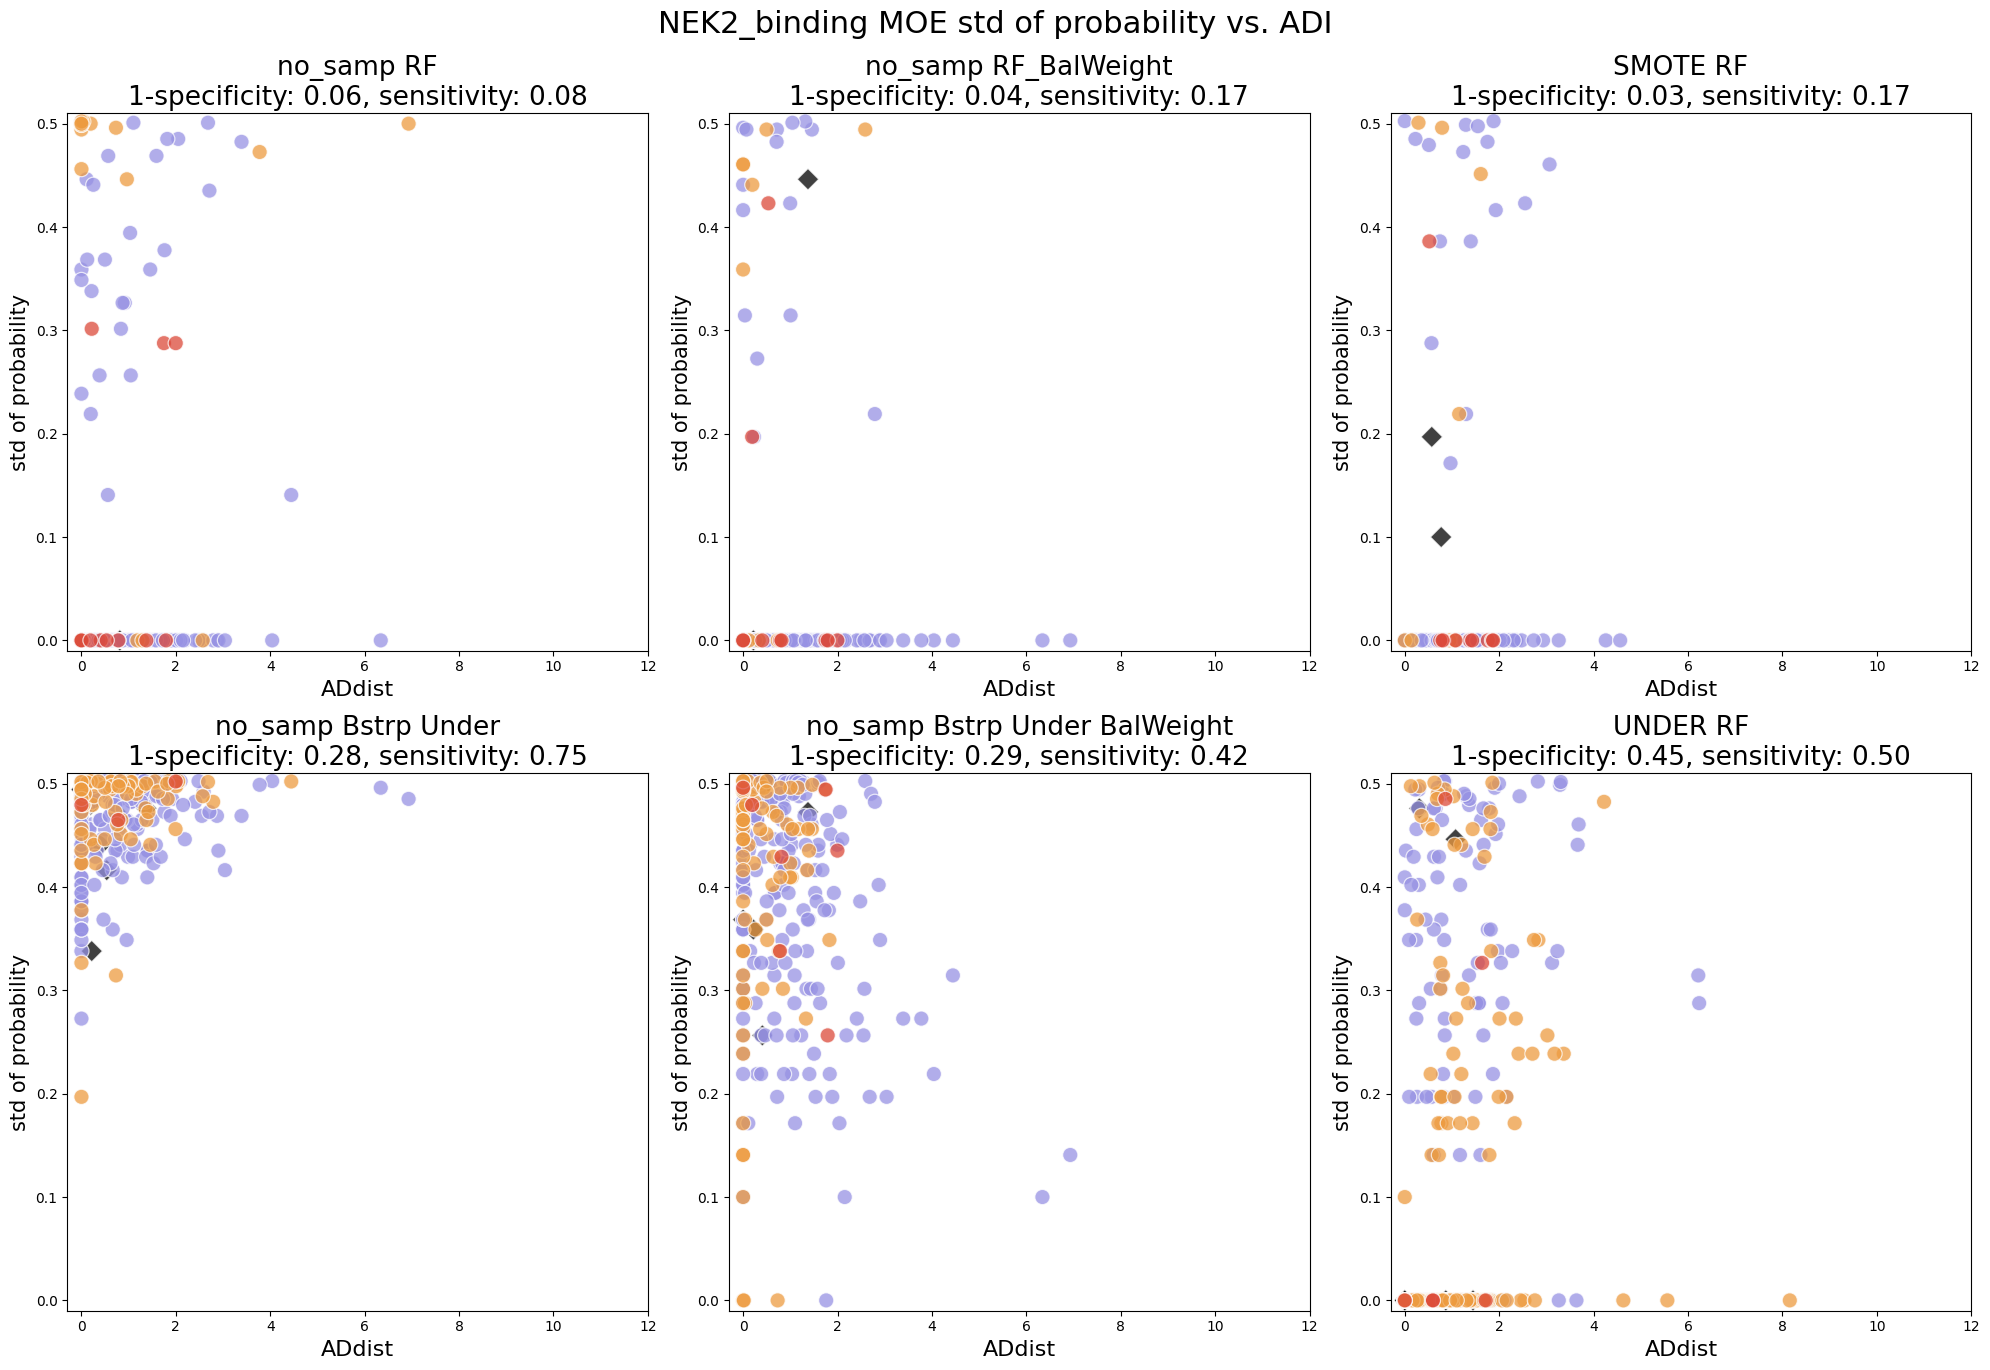

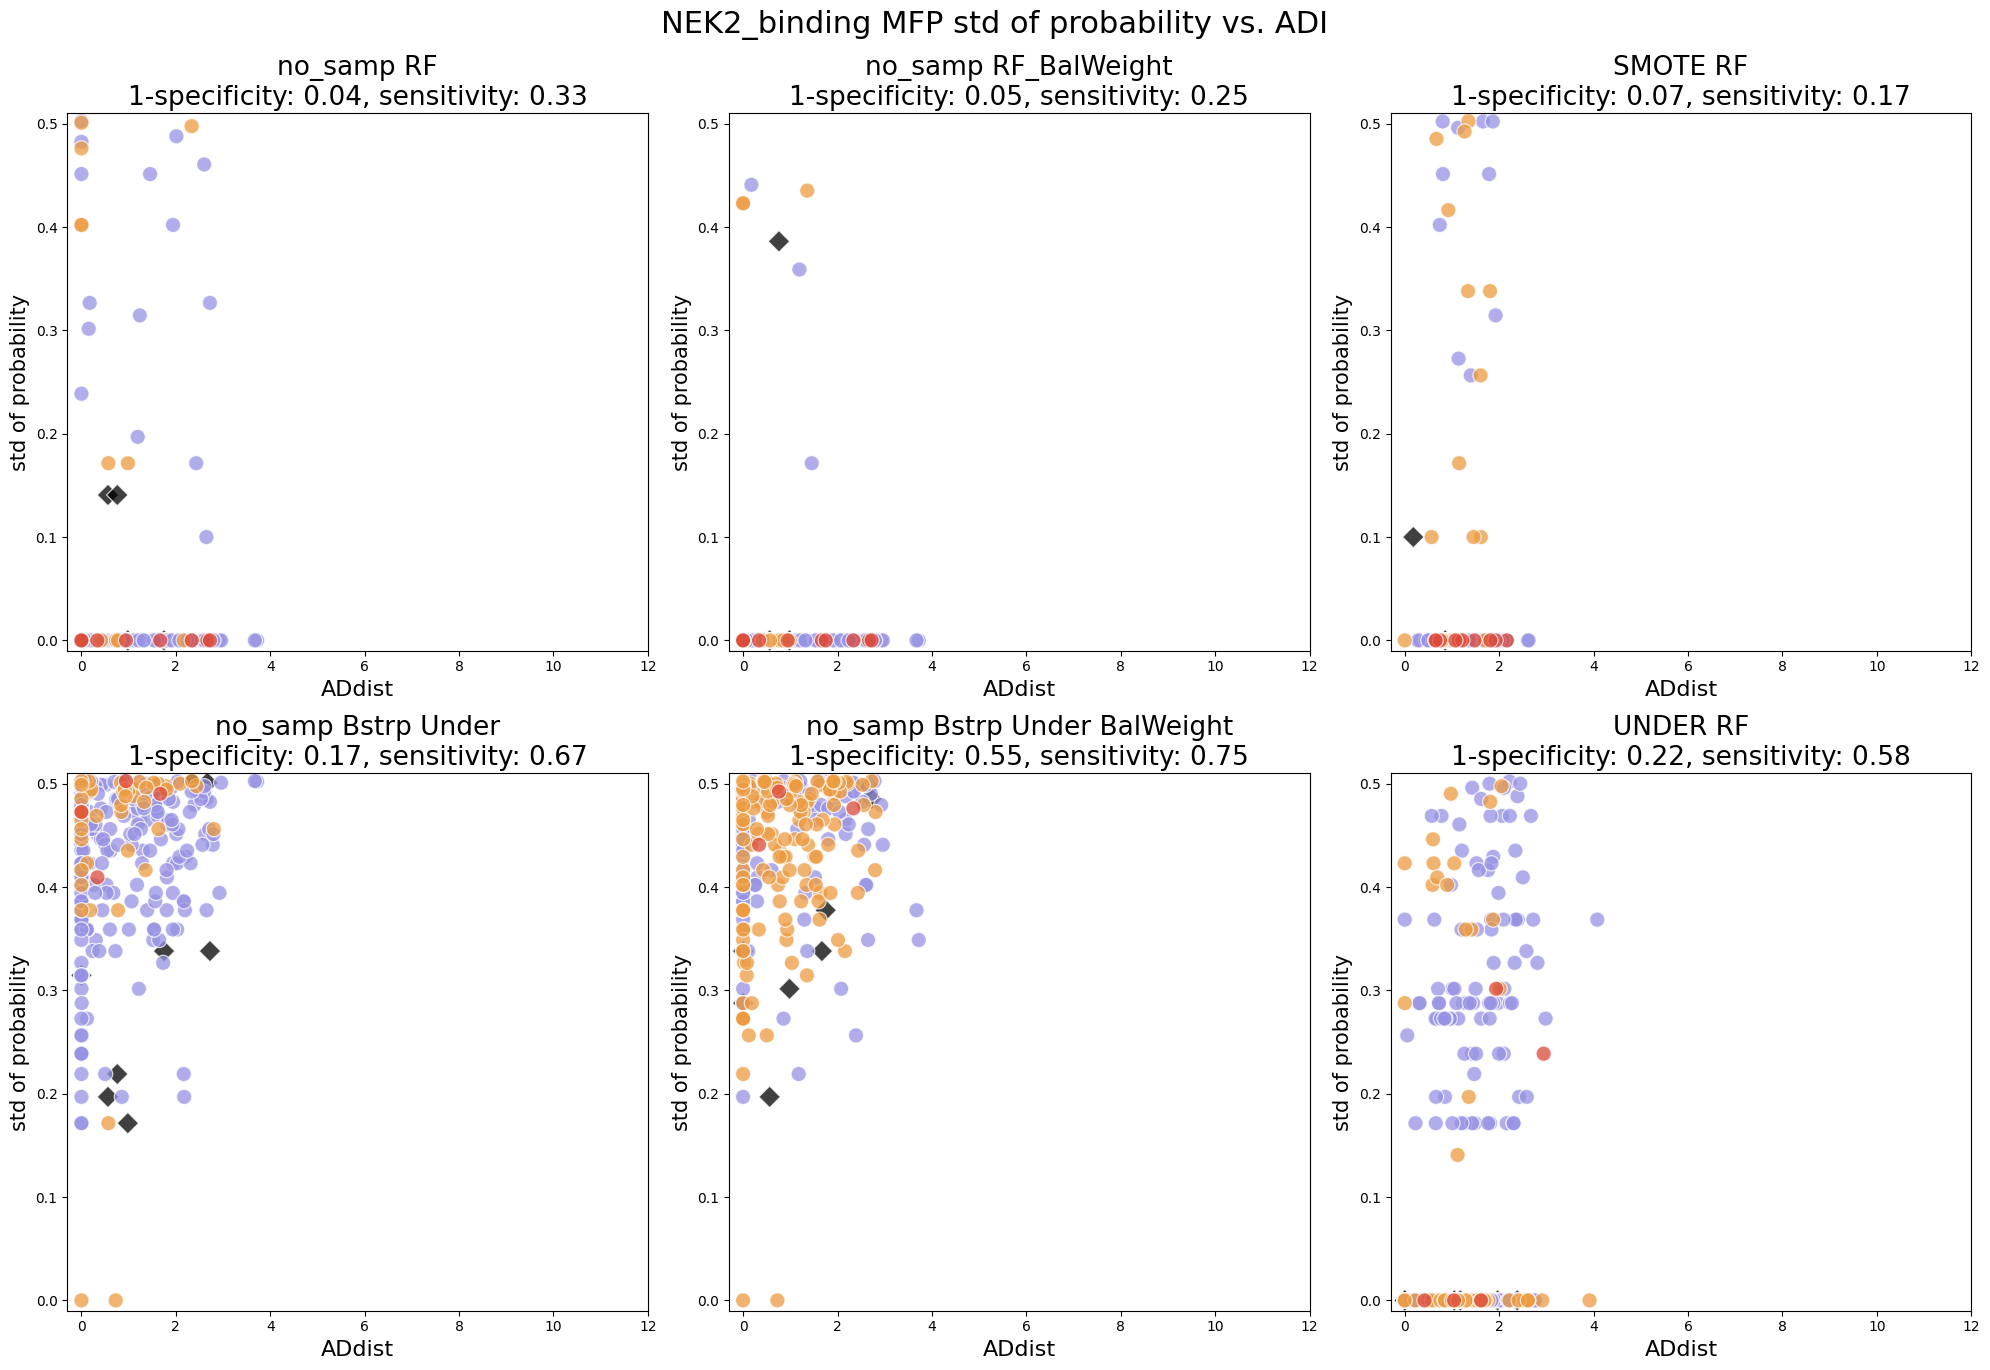

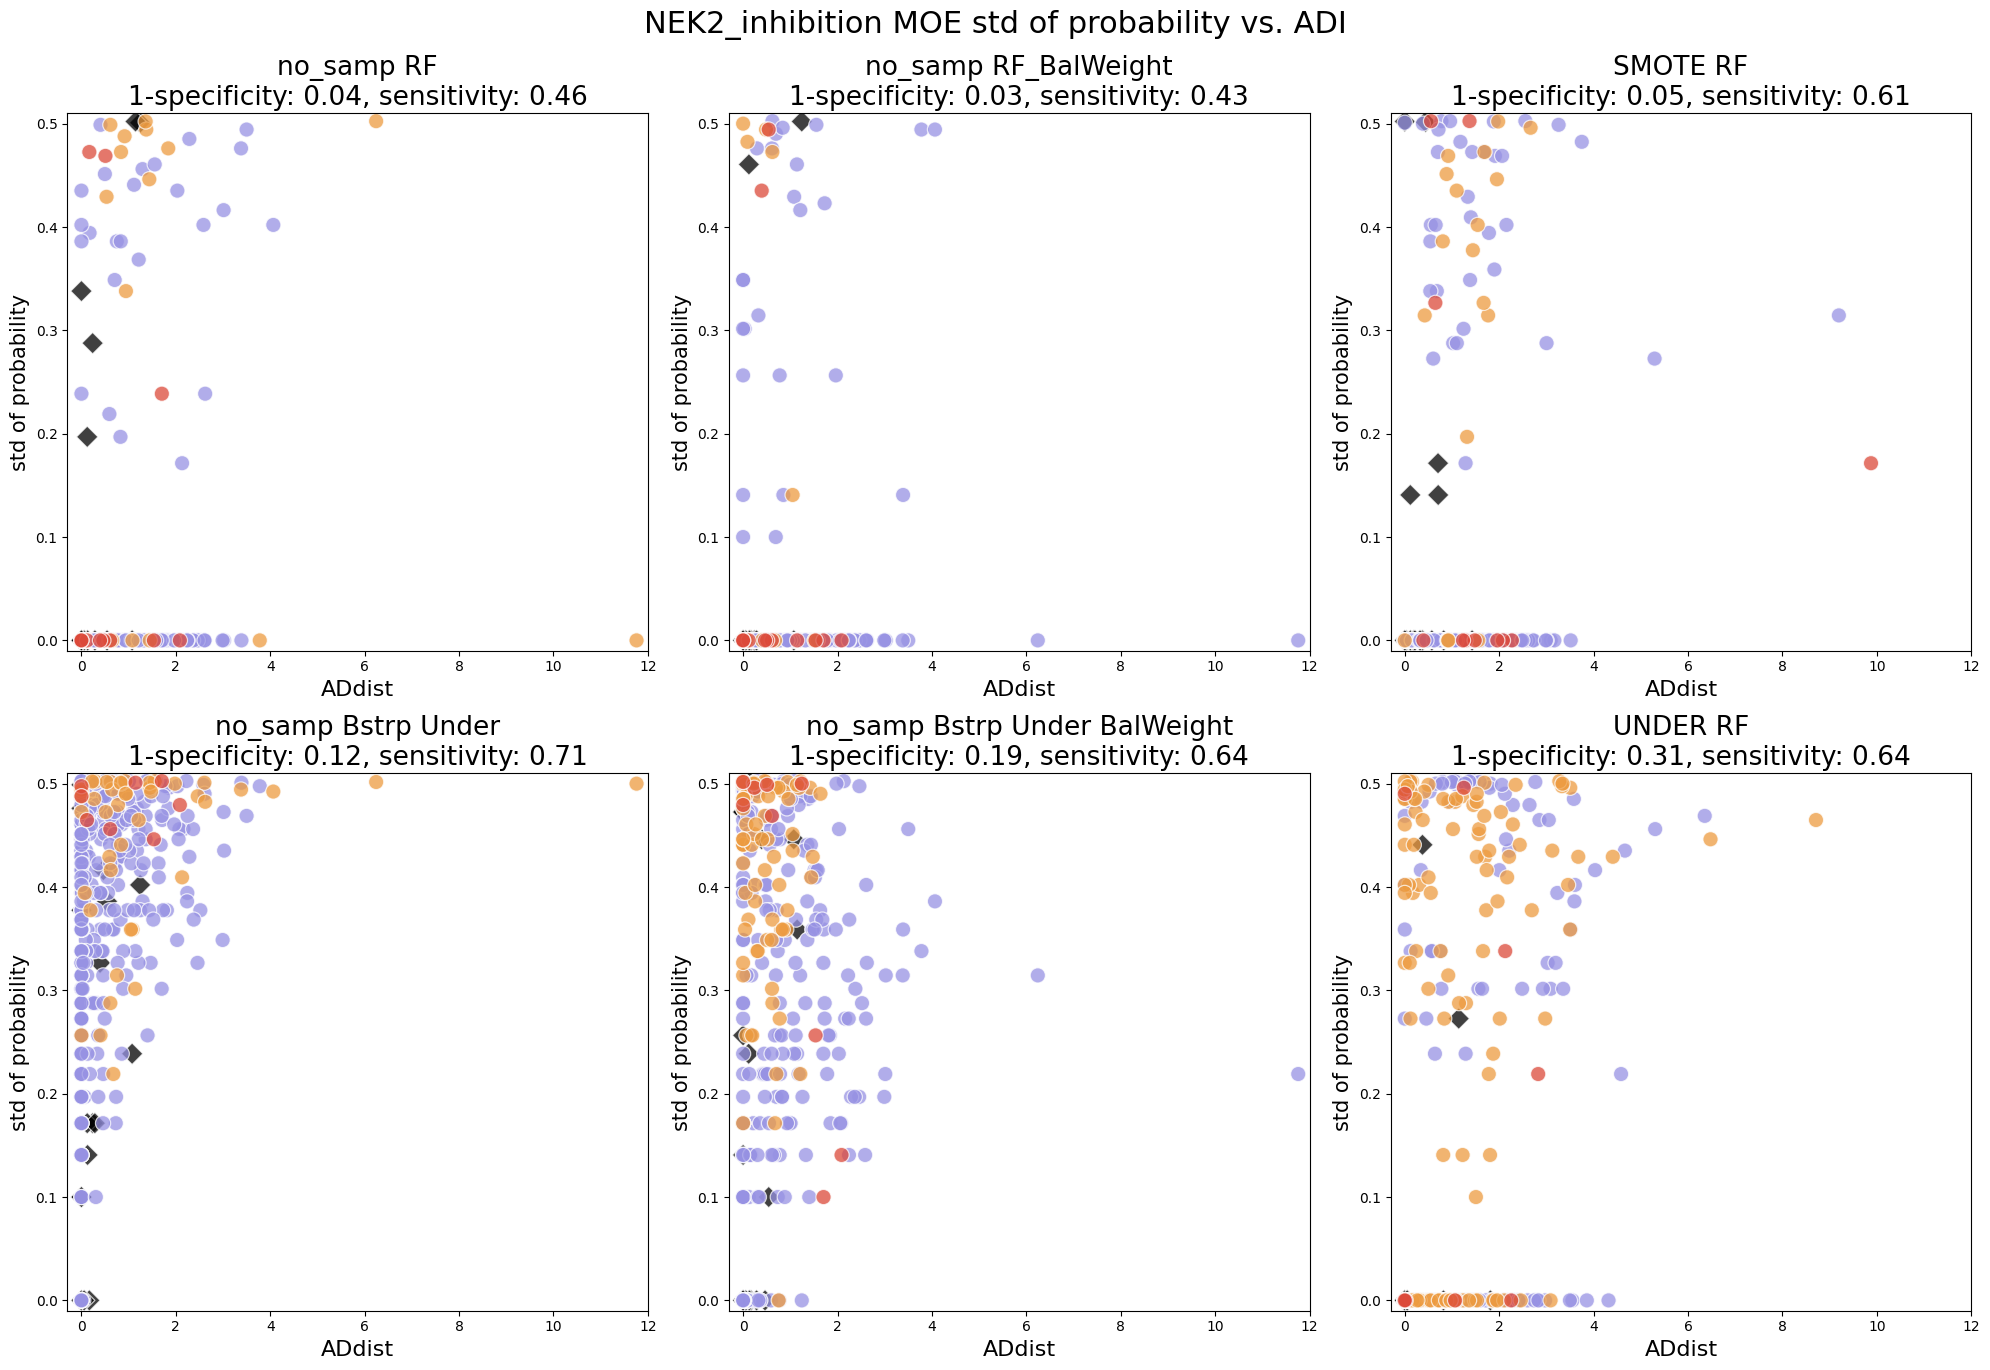

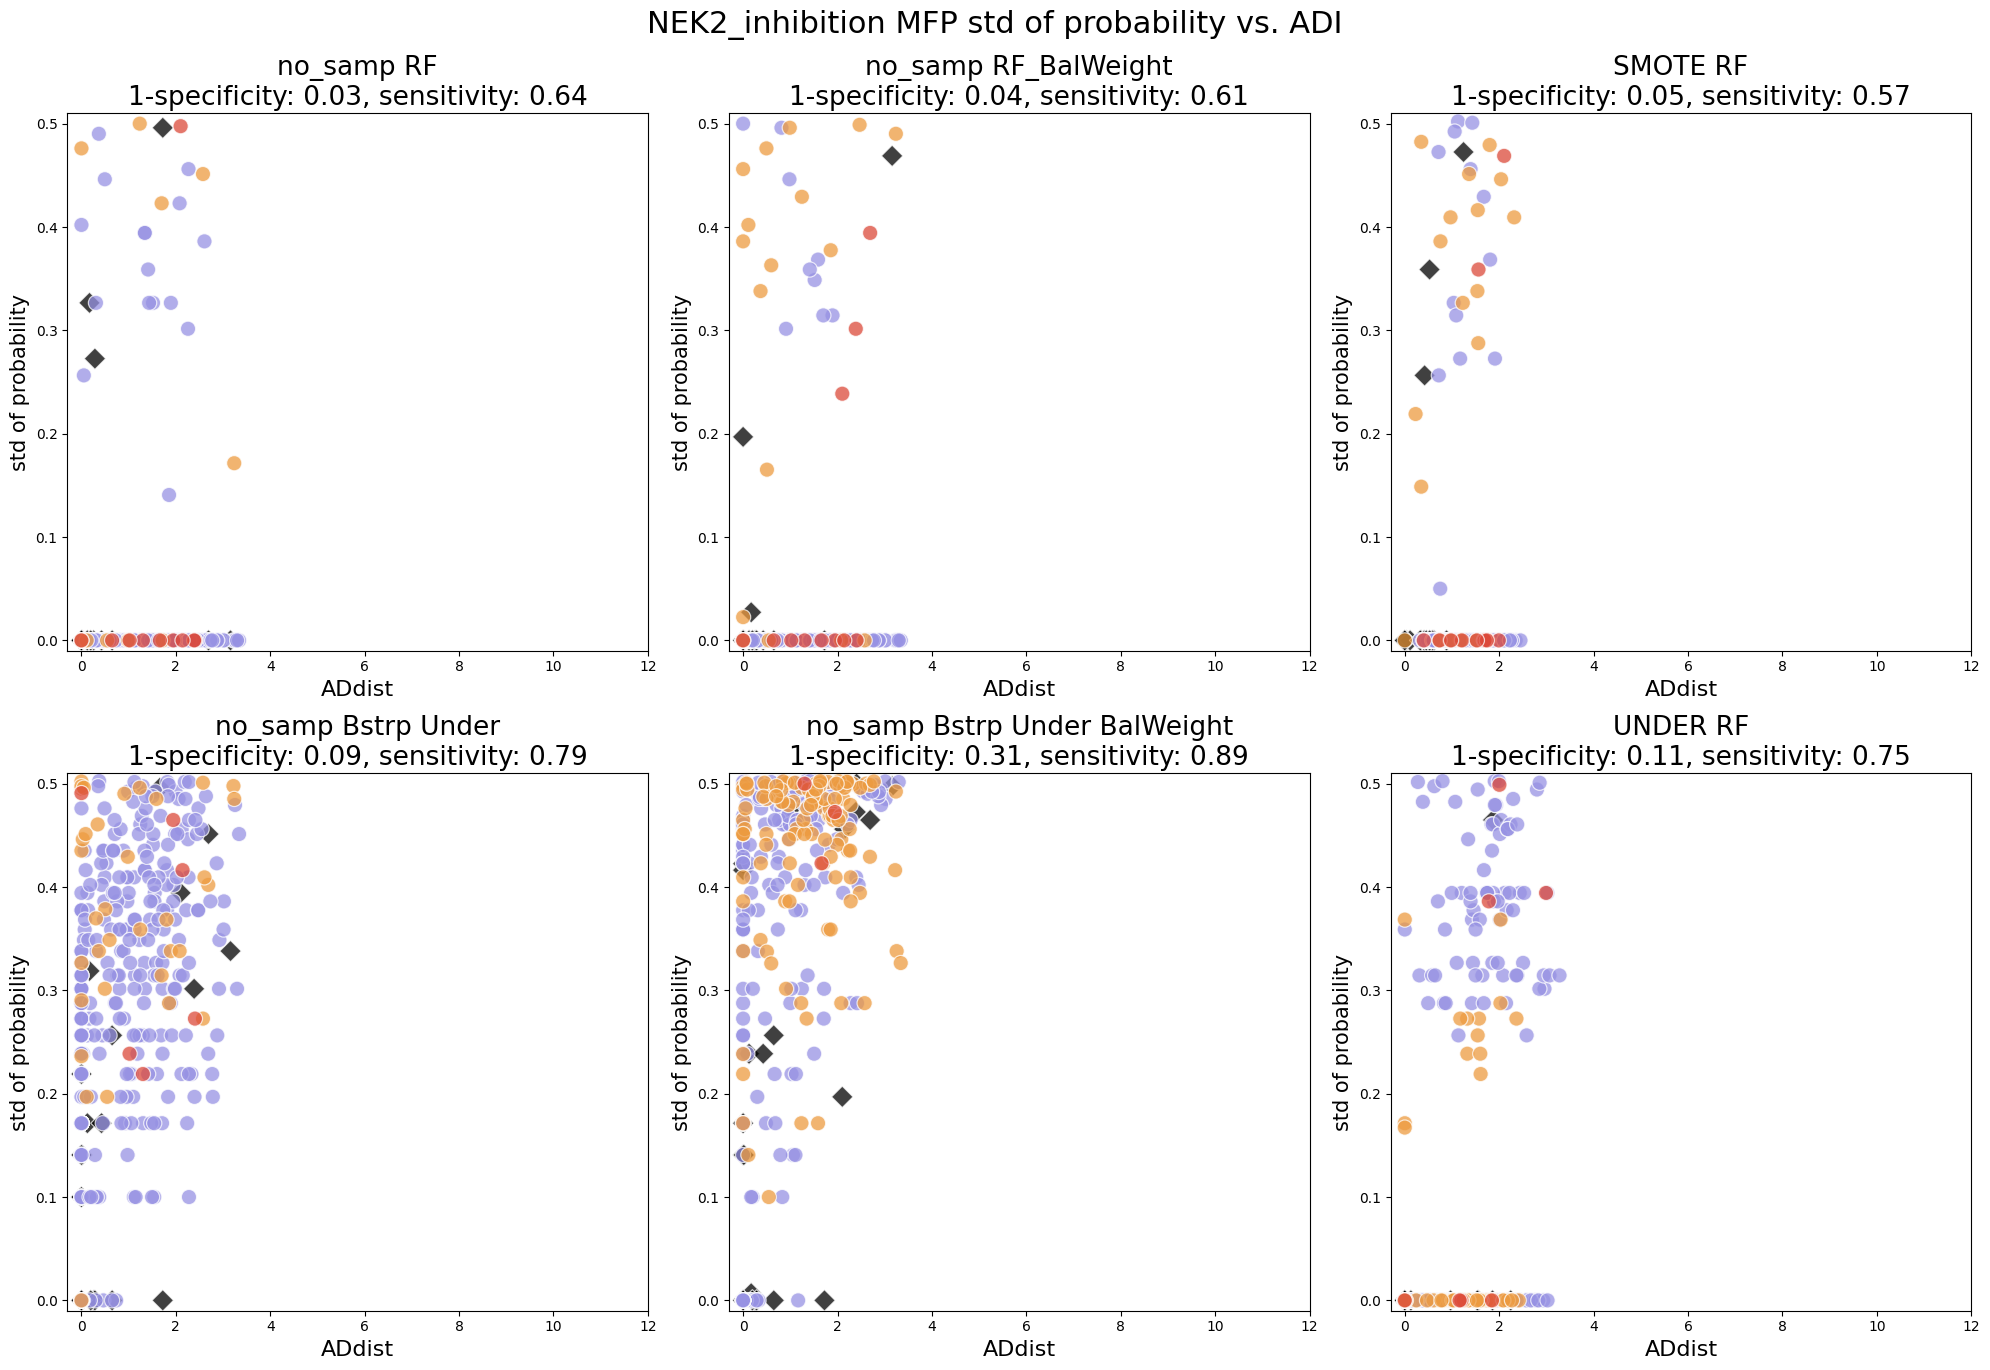

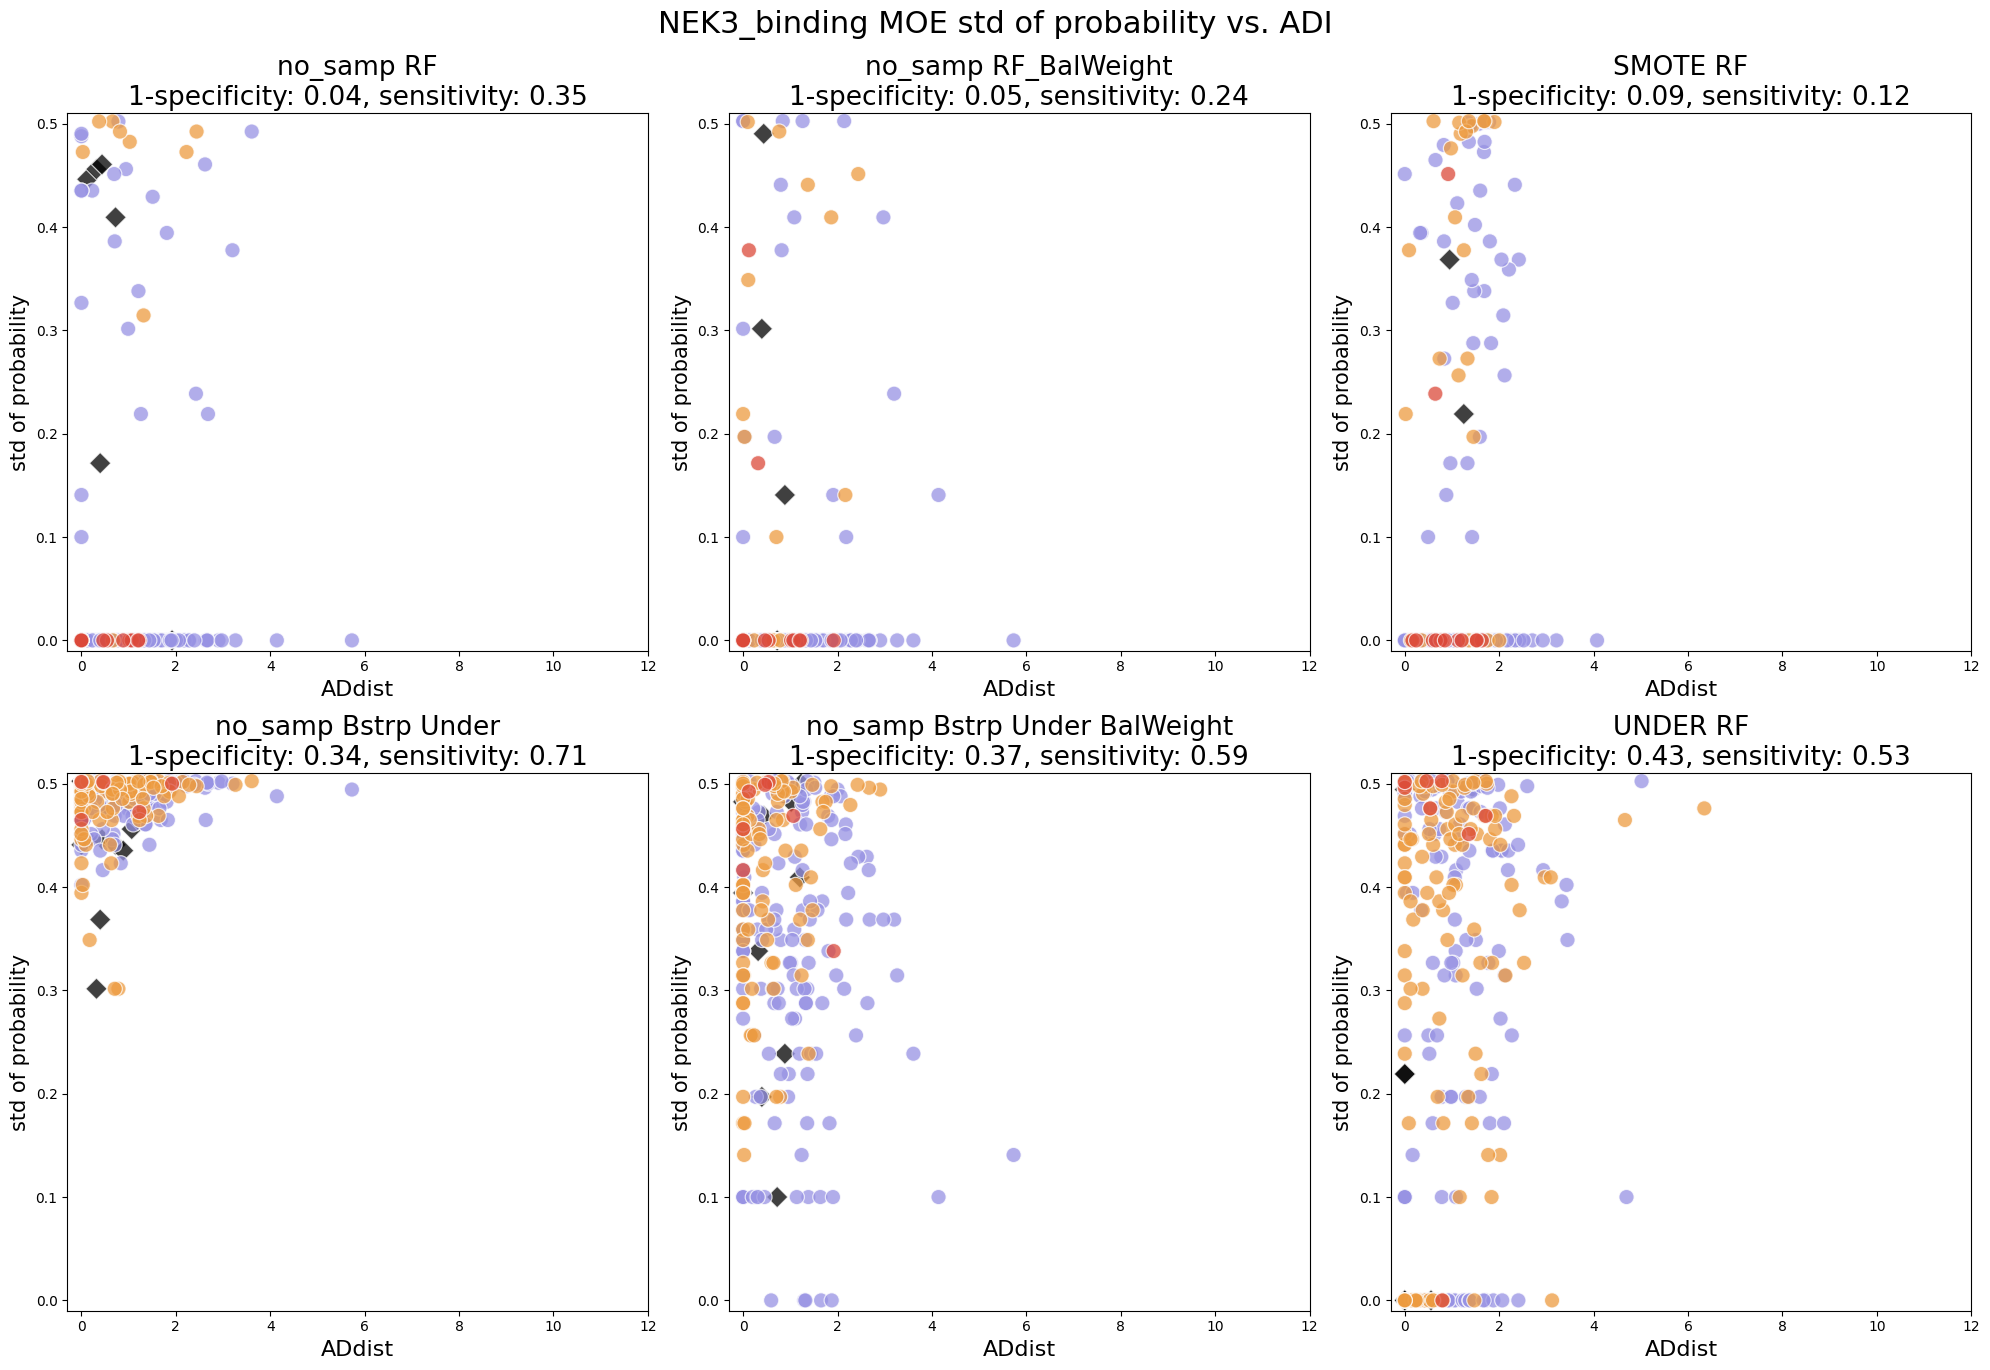

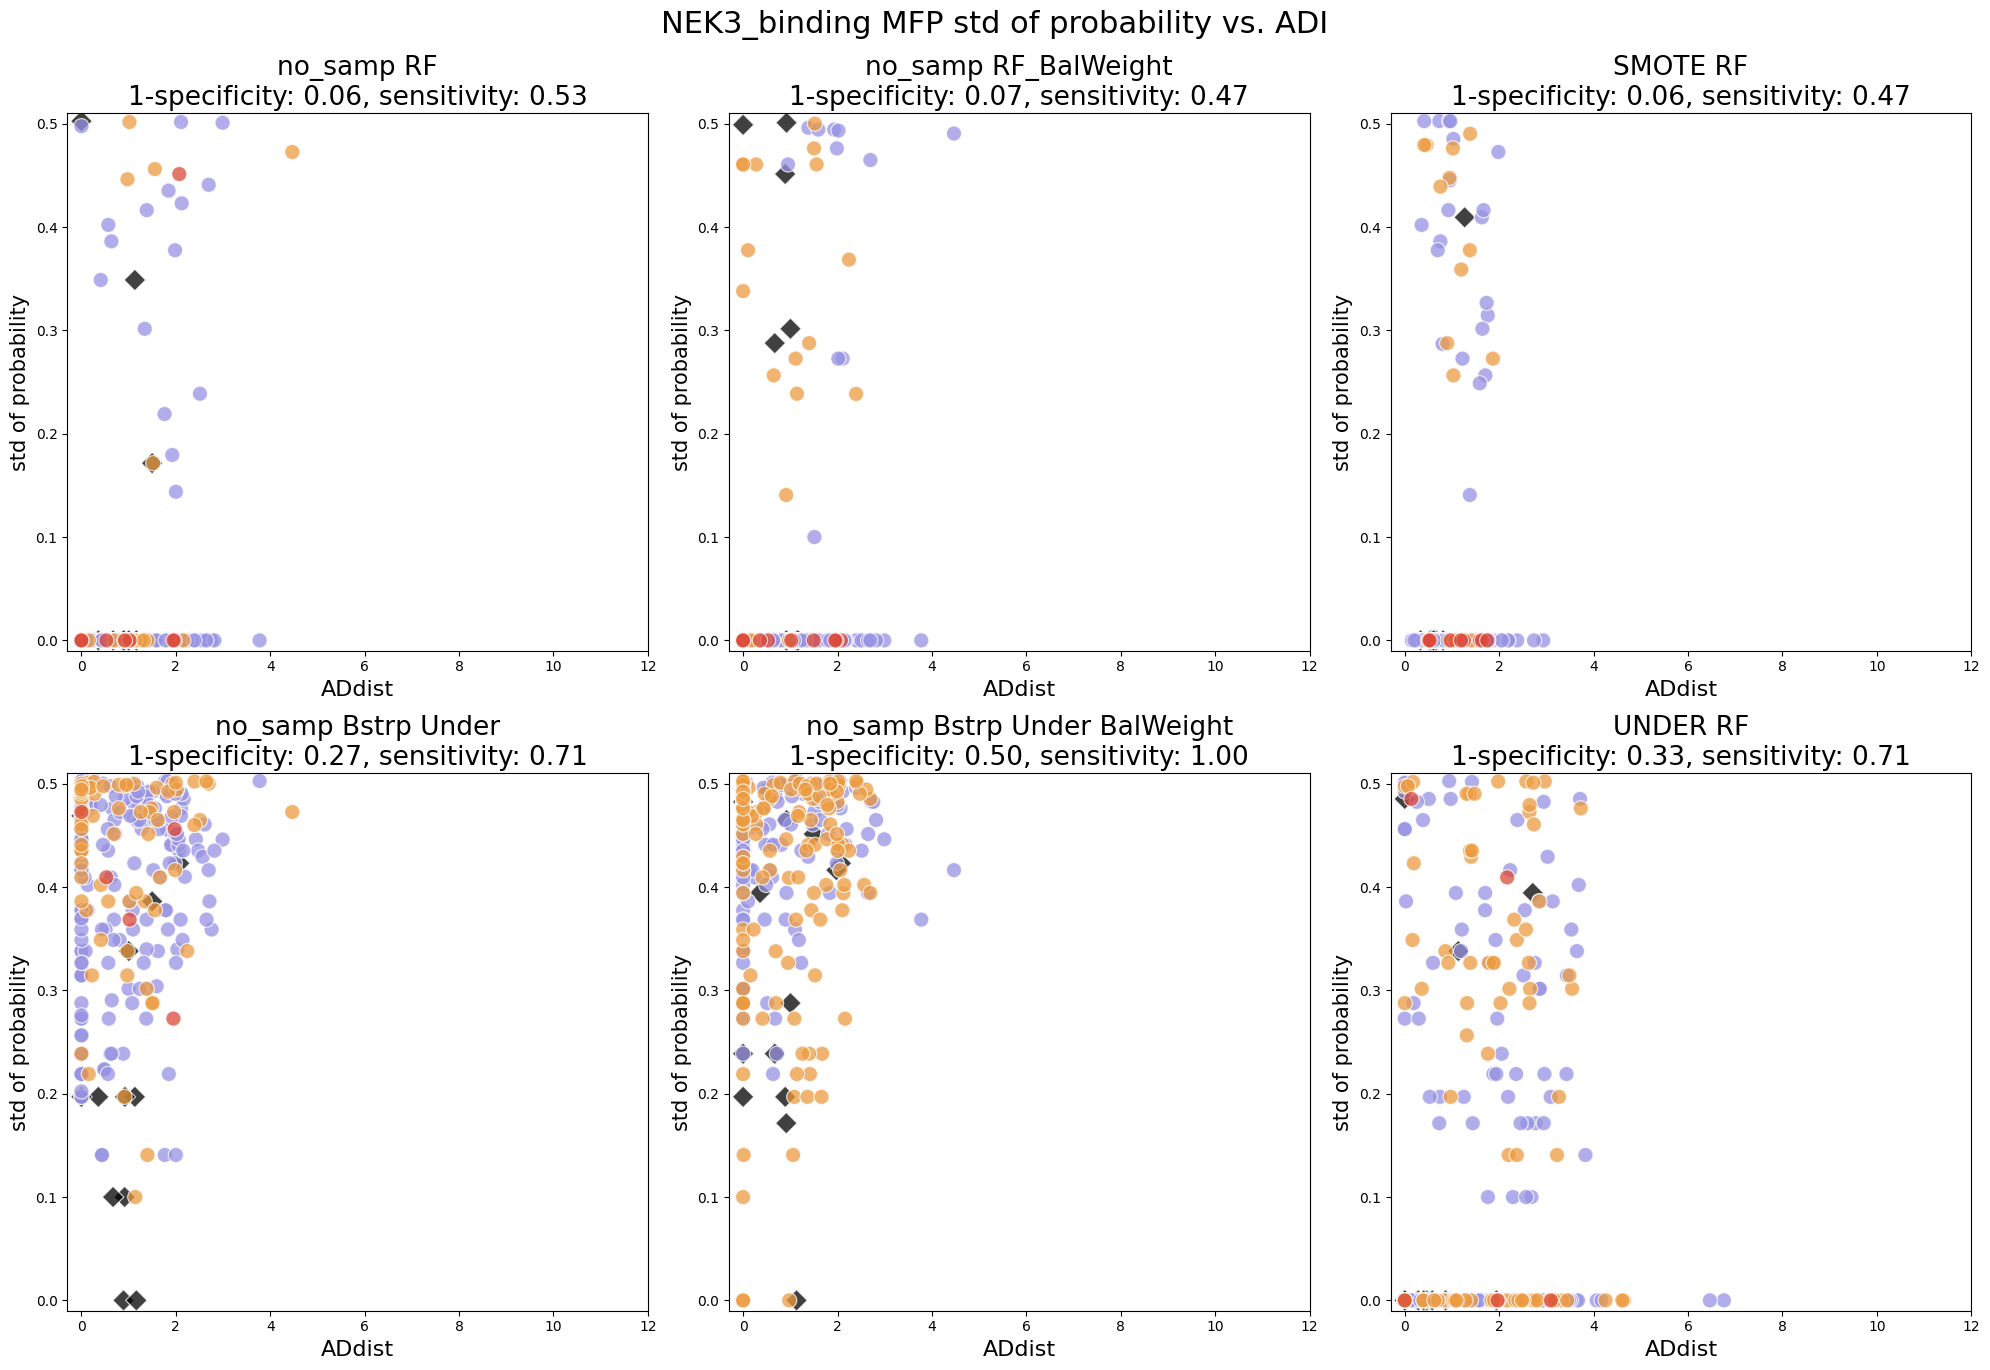

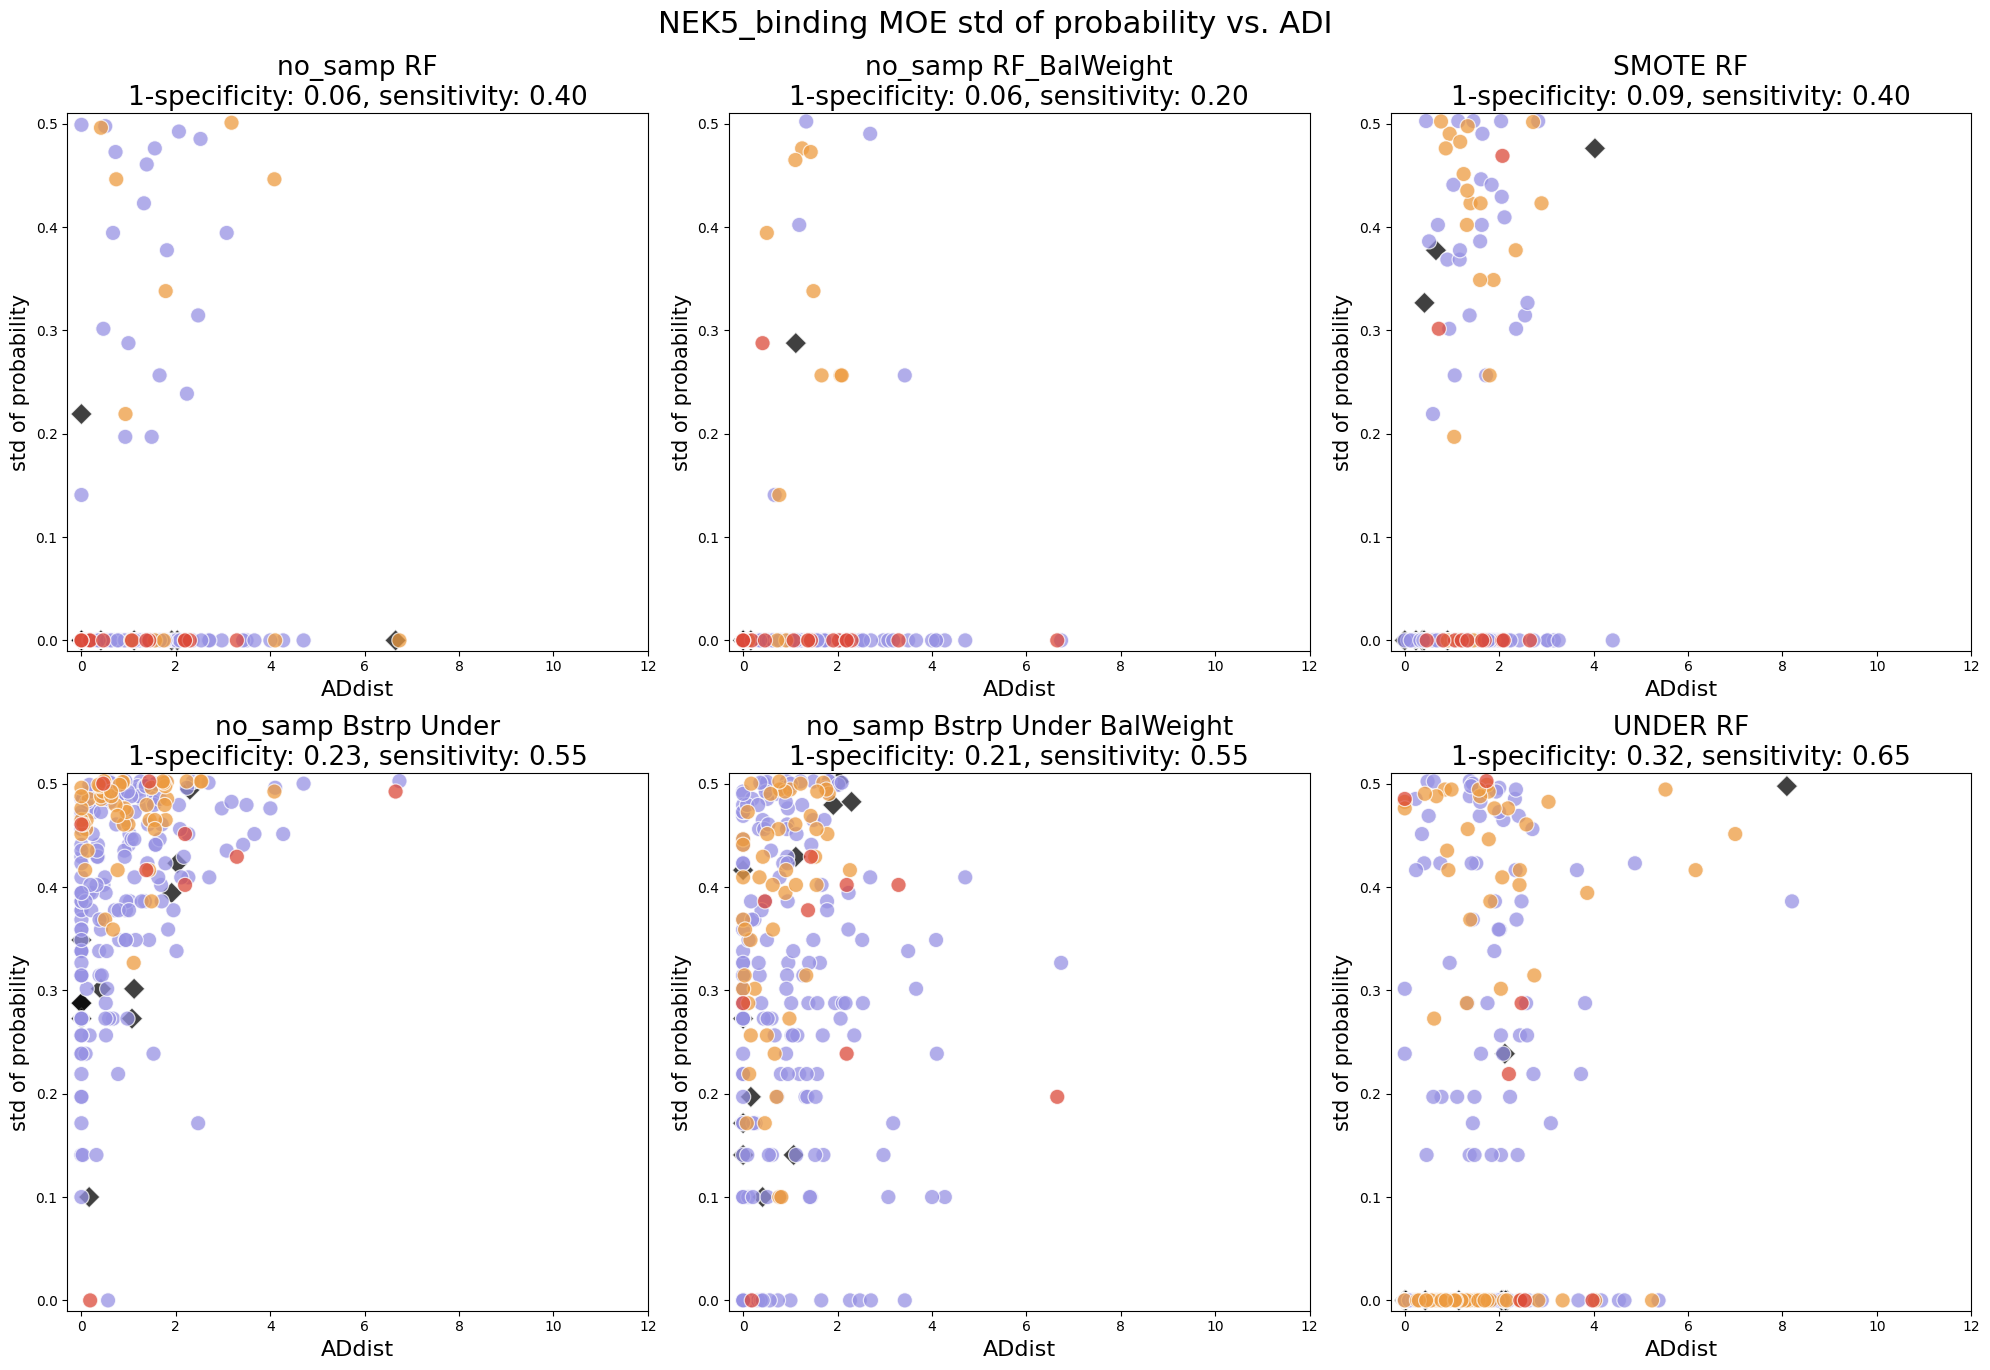

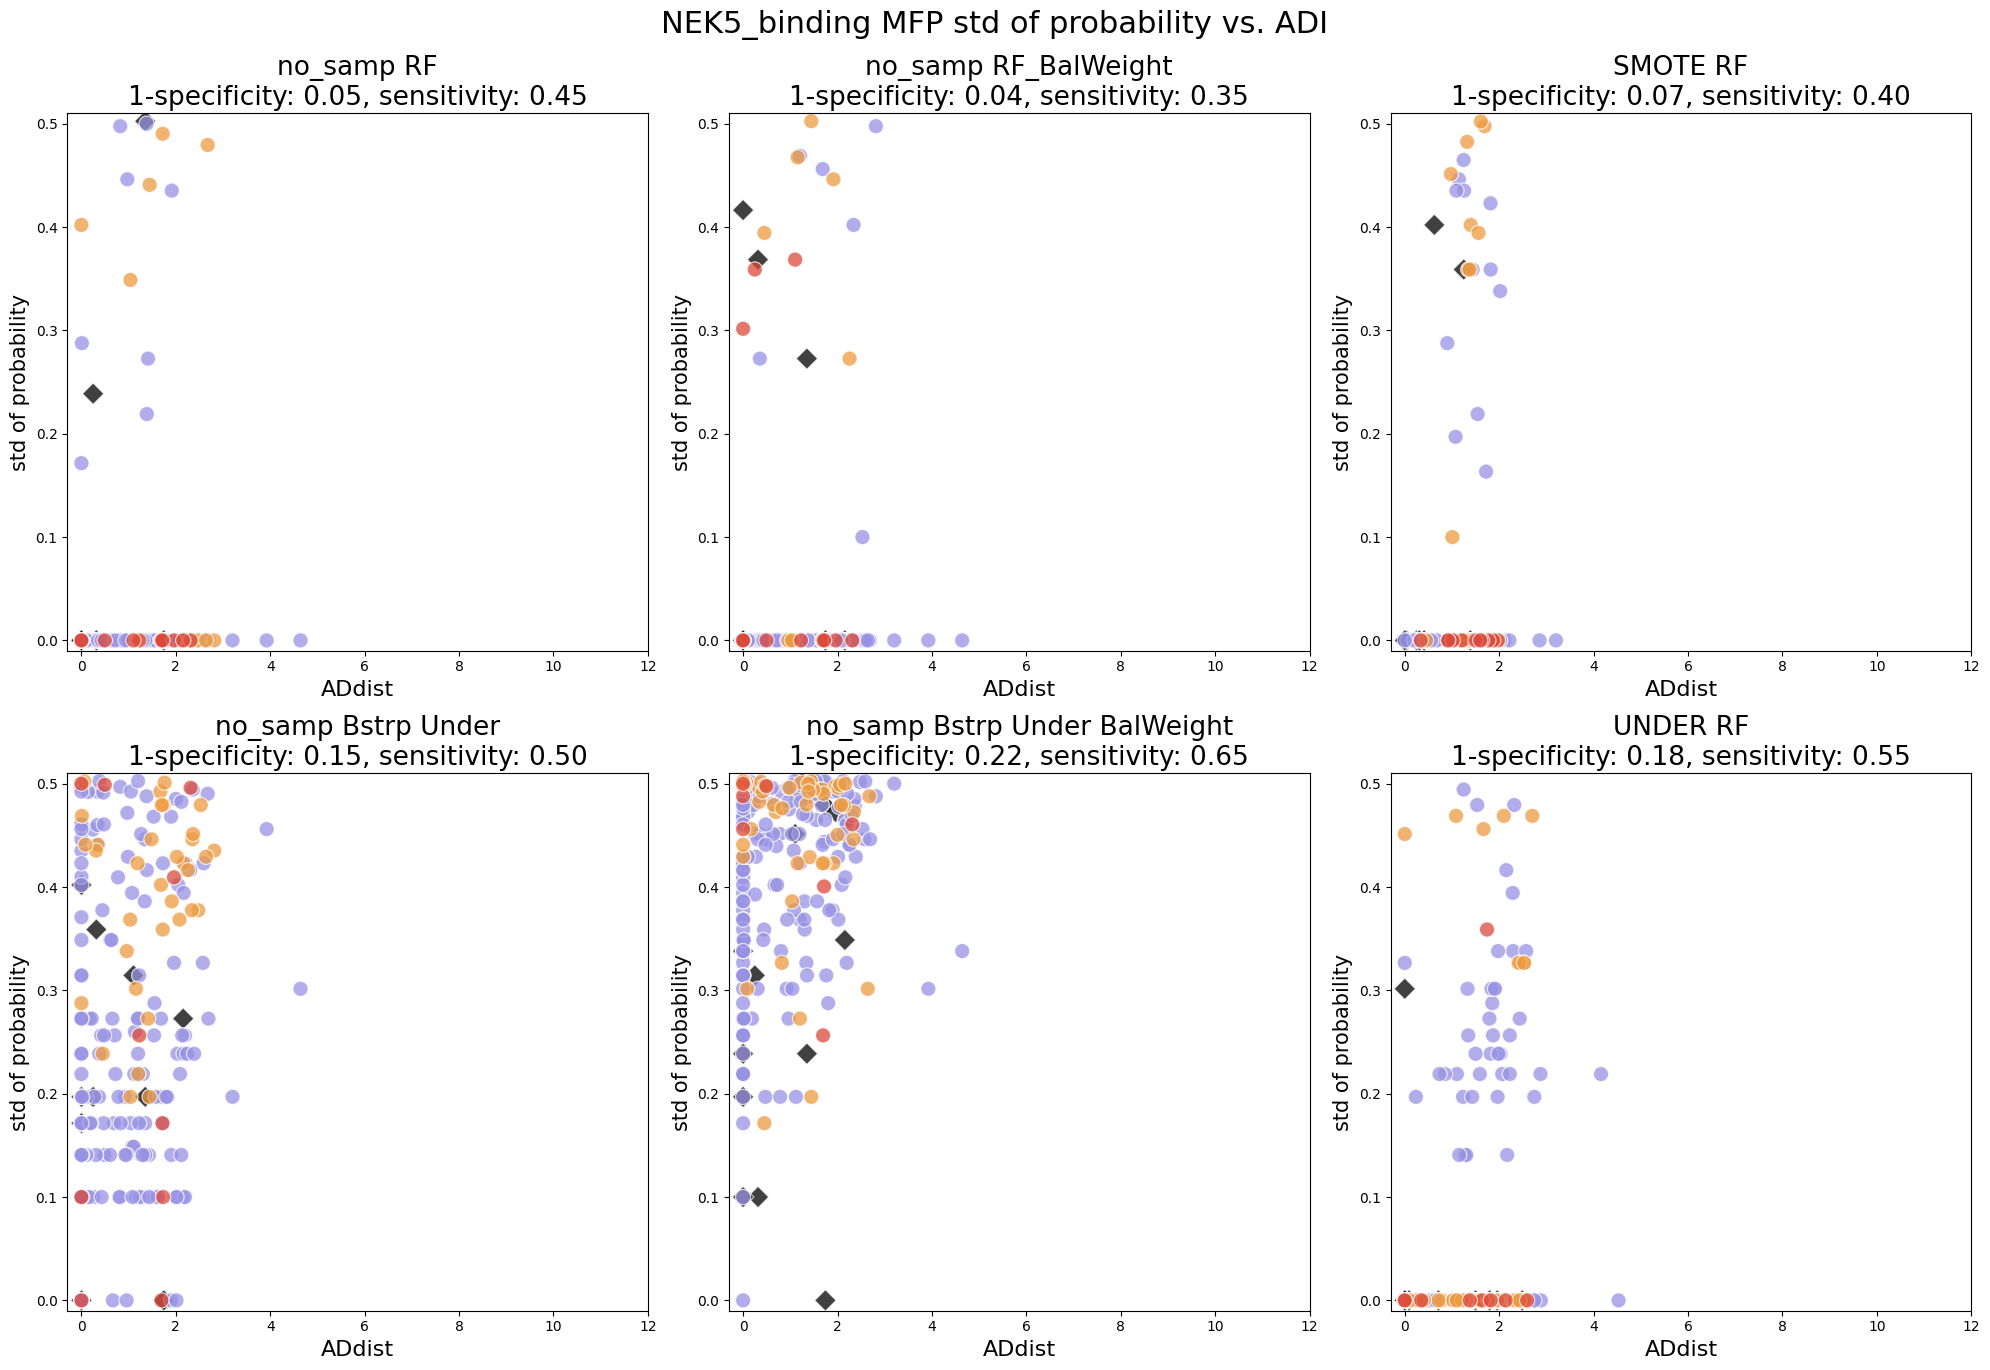

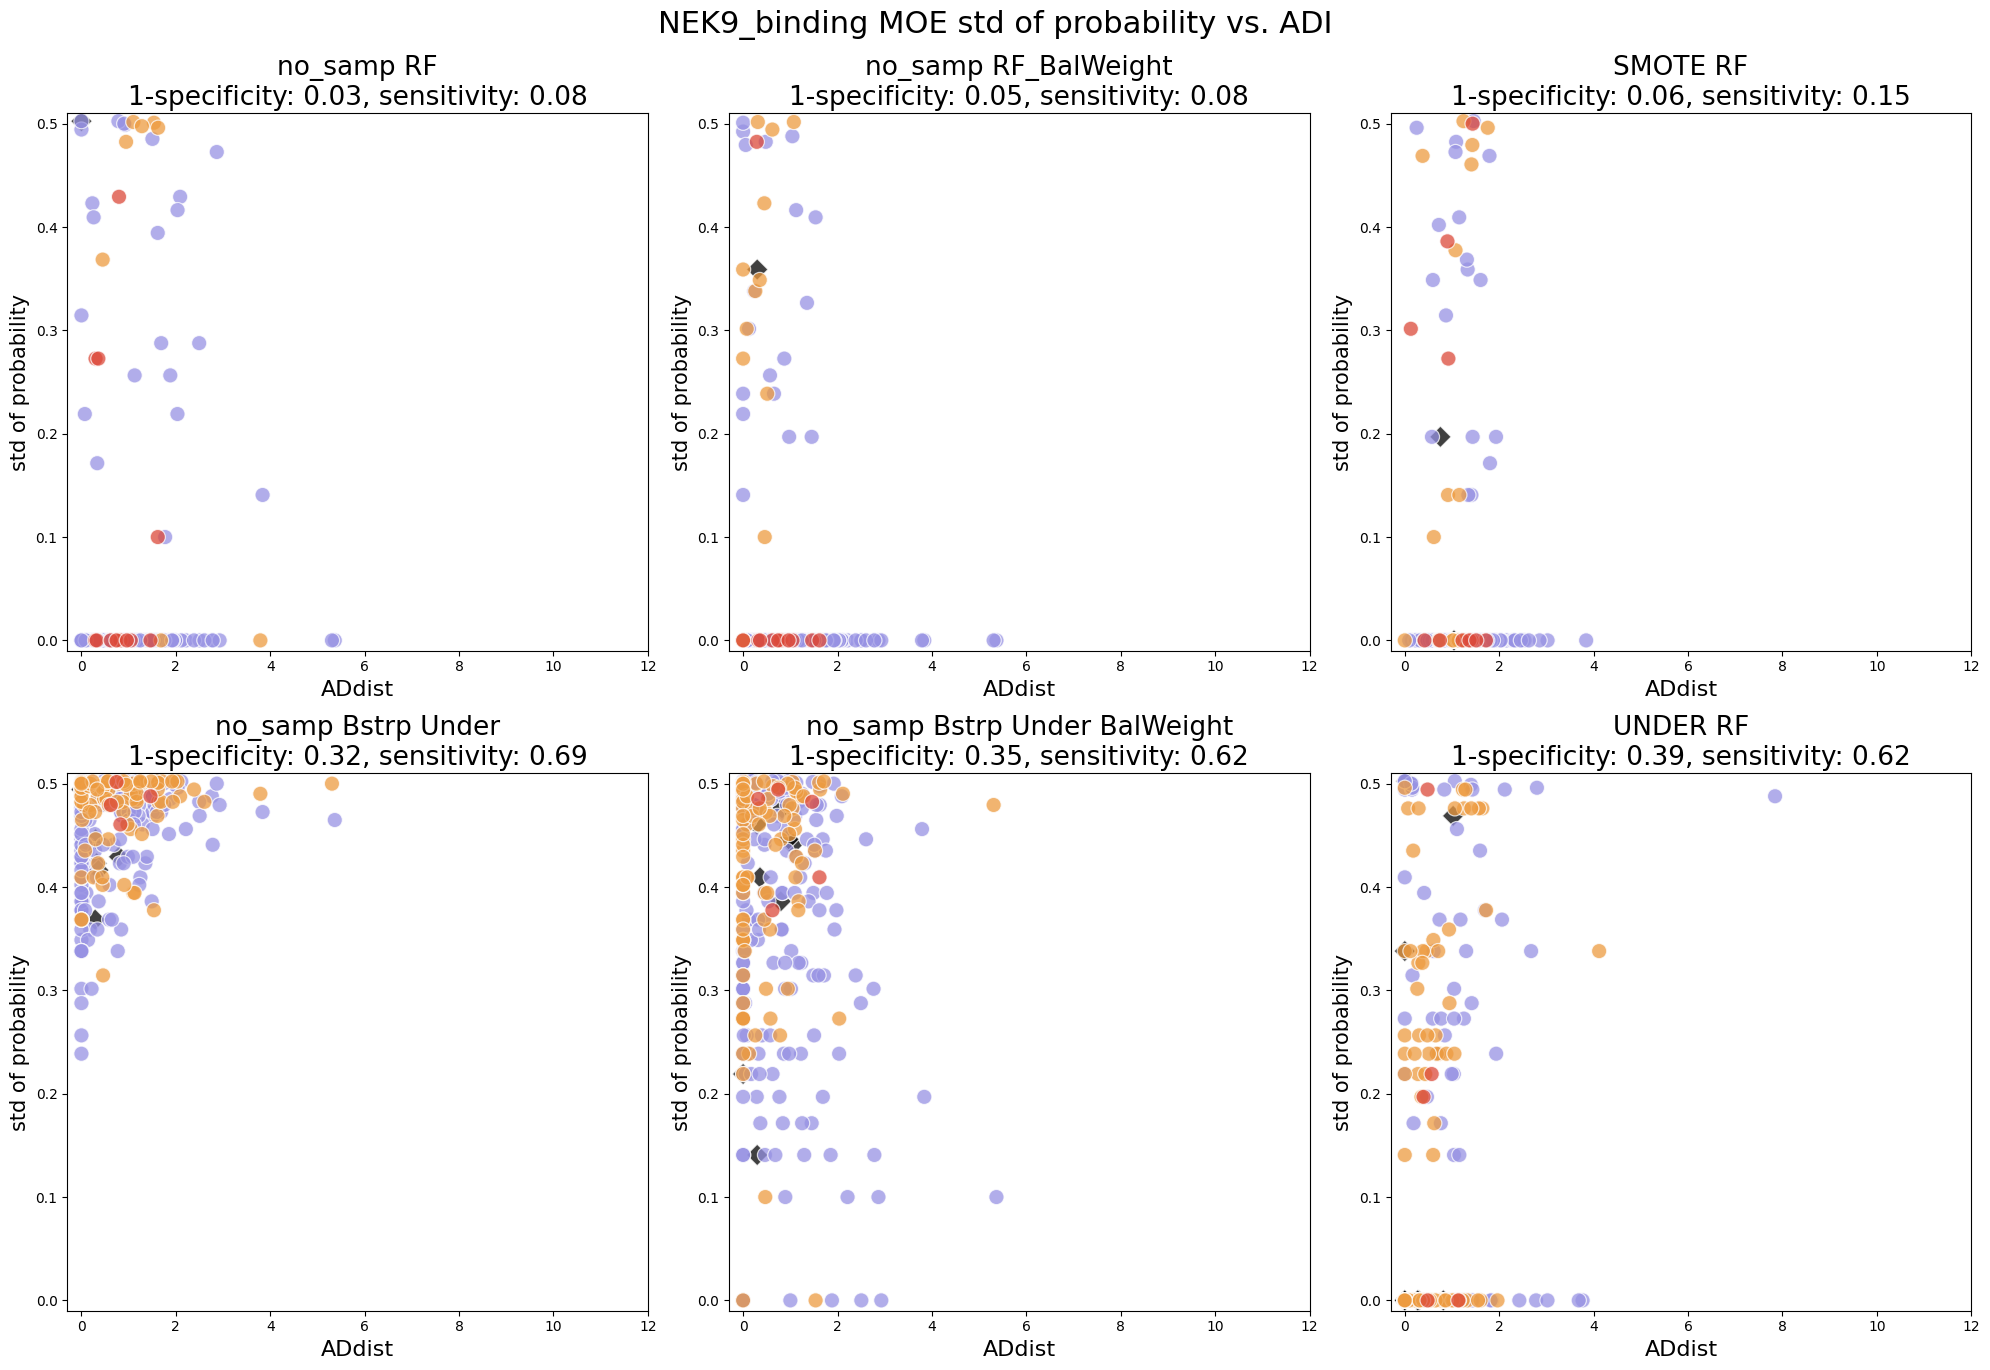

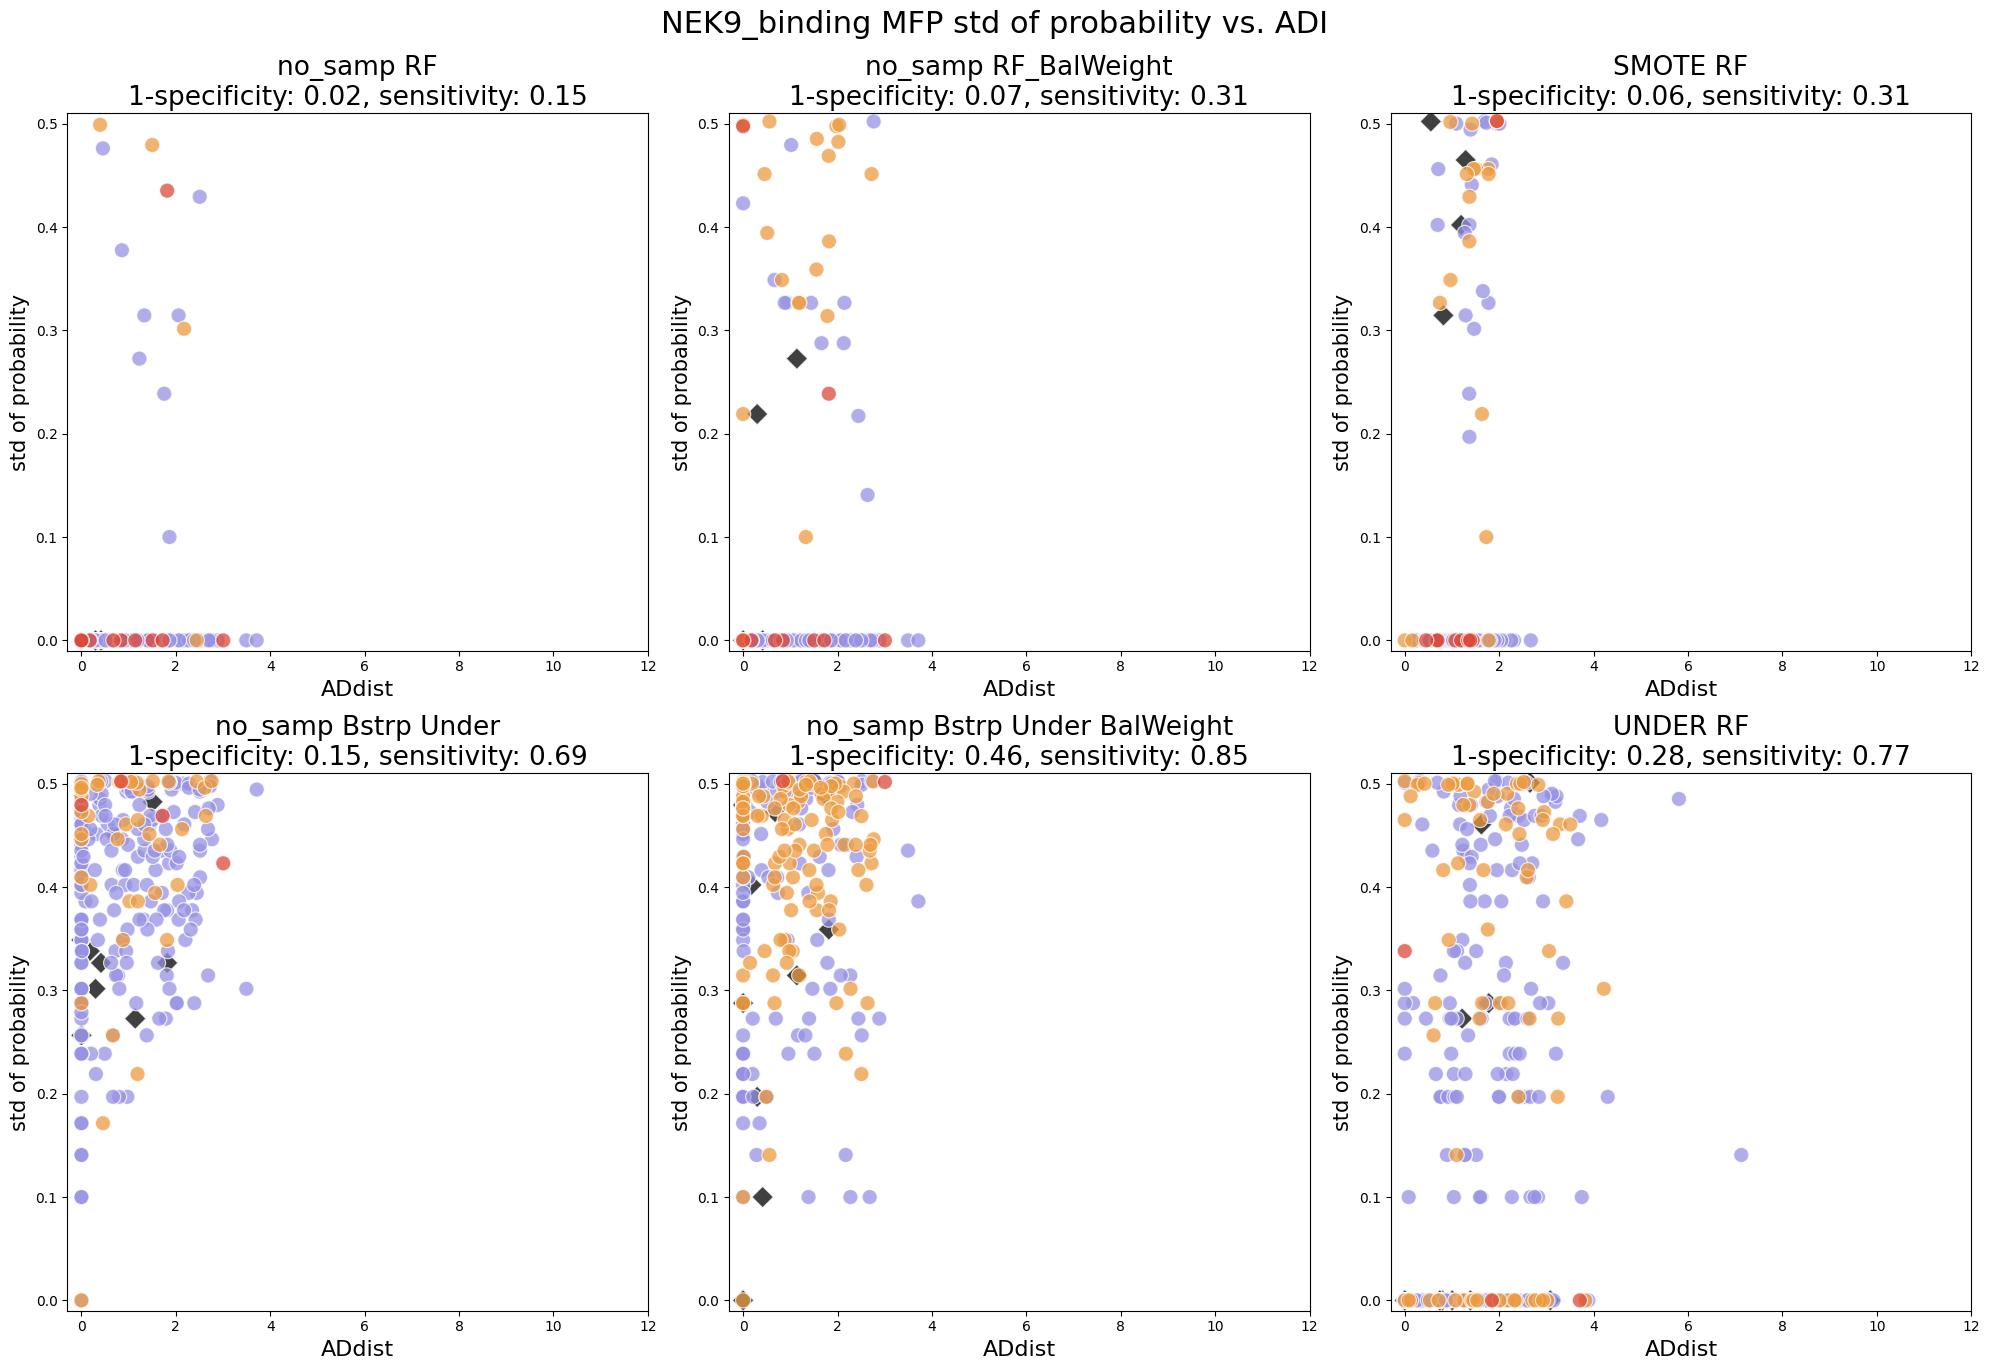

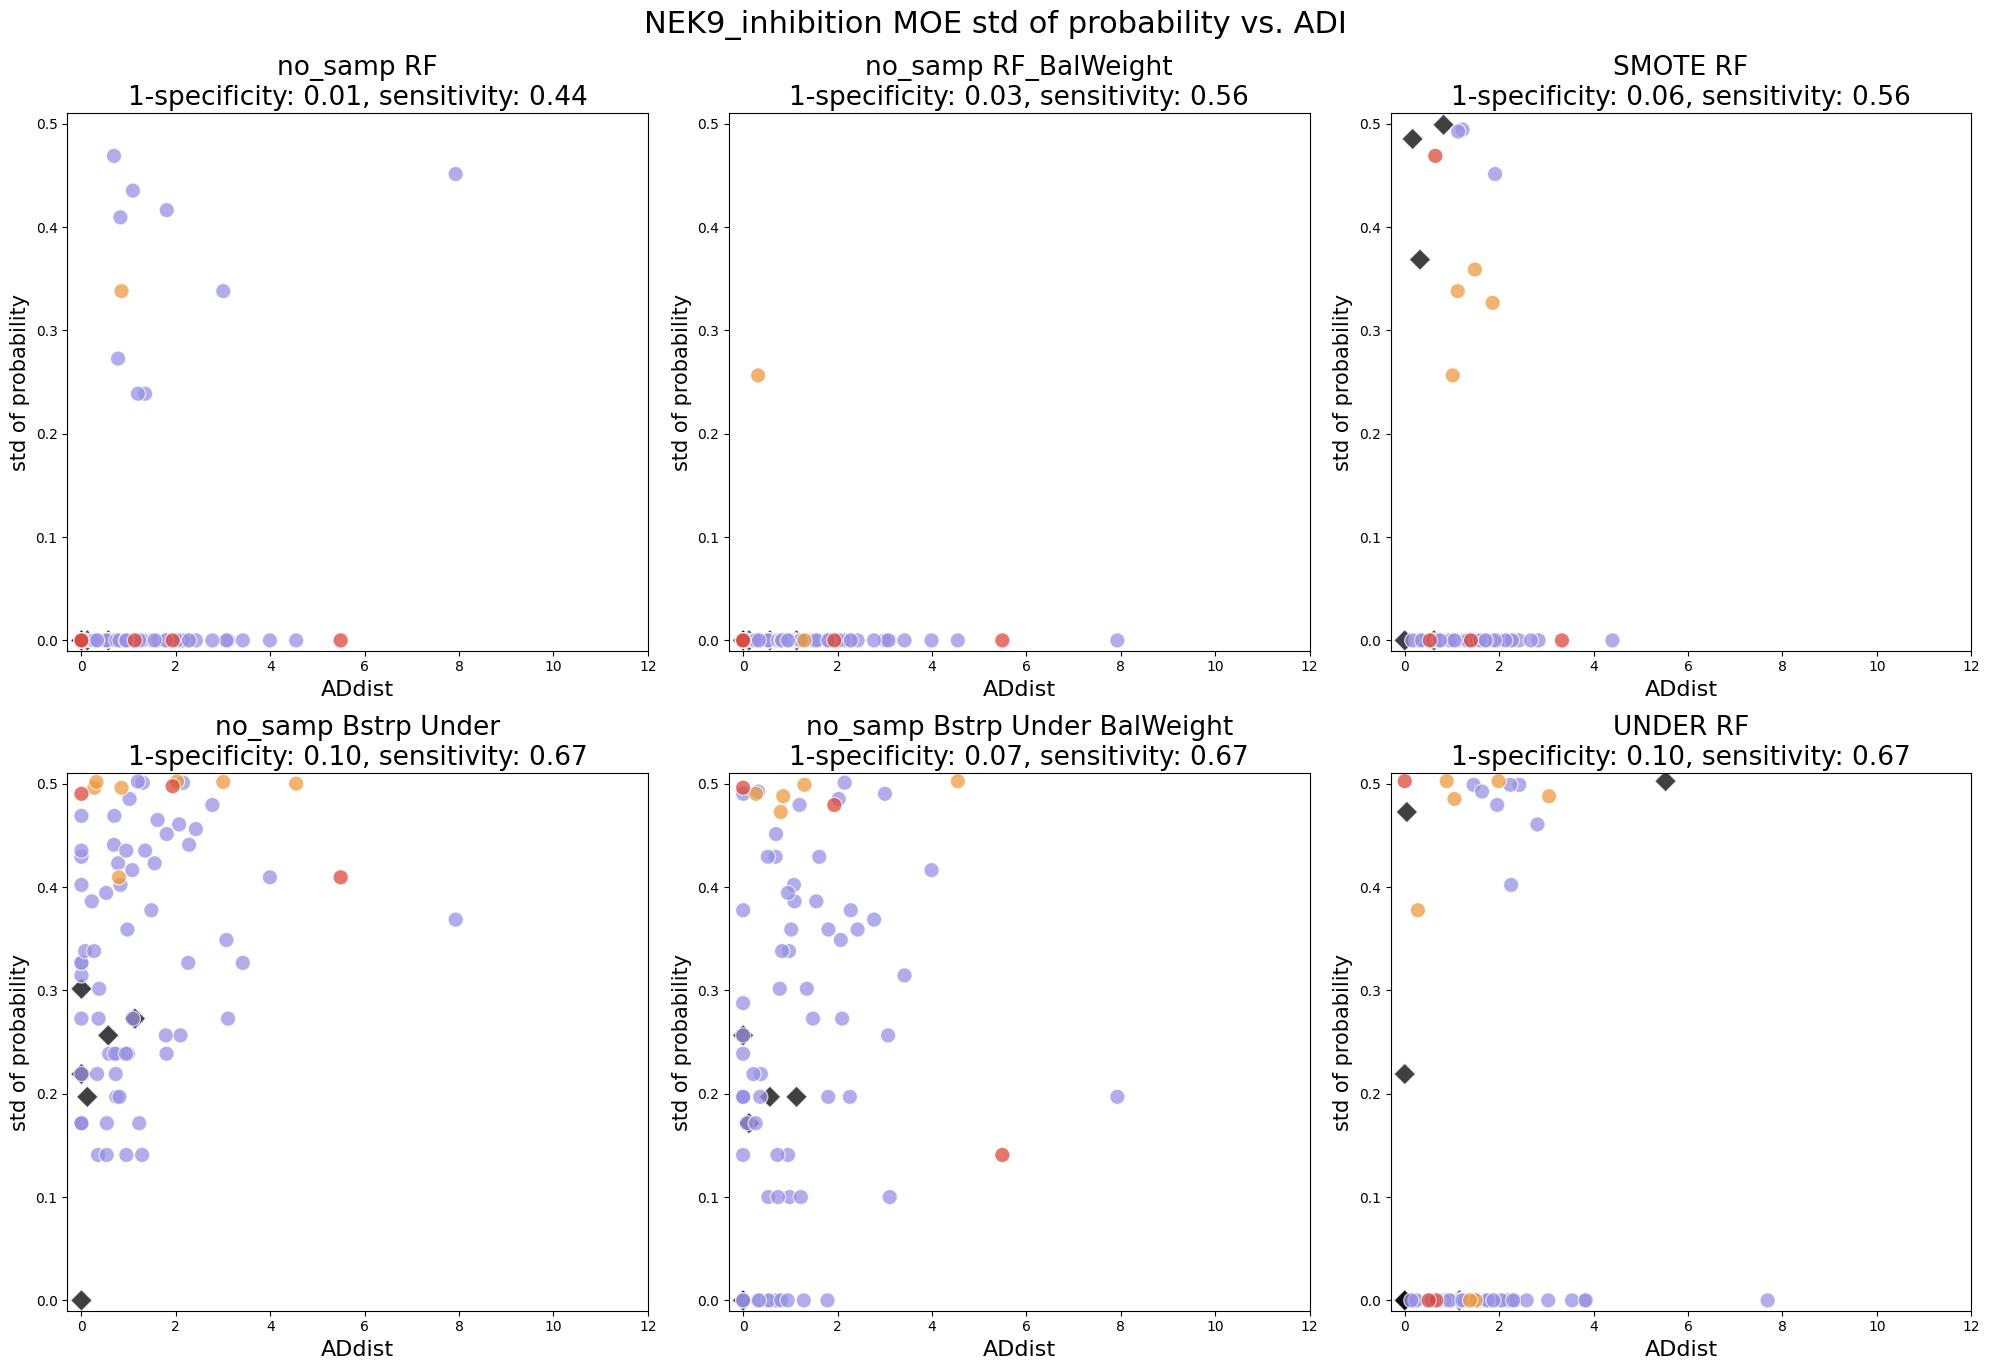

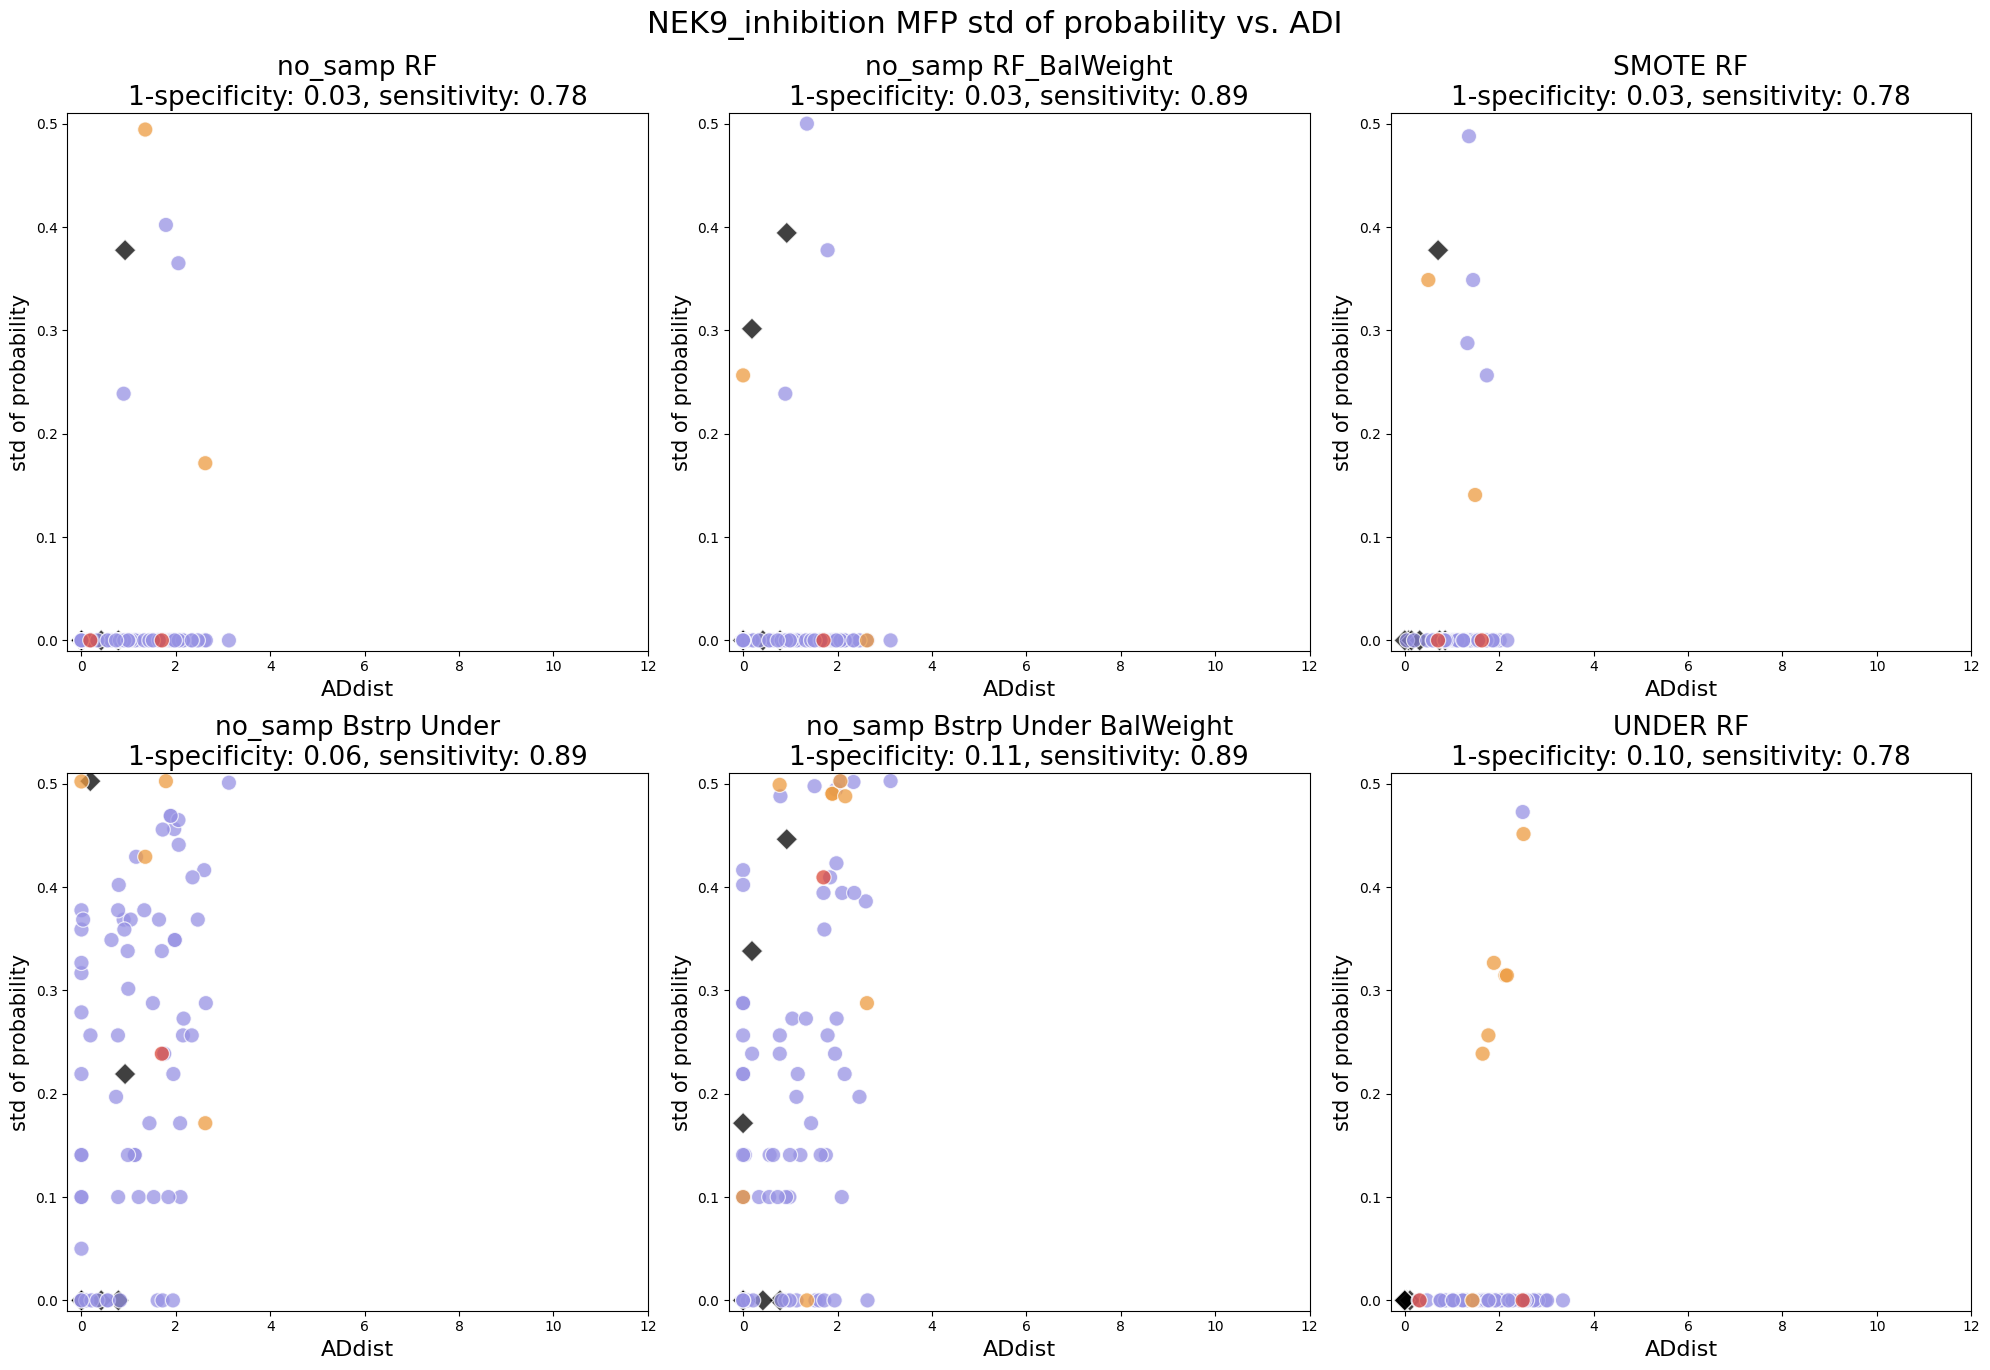

In [22]:

def change_names(df): 
    df['strategy']=df['strategy'].replace('none_scaled', 'no_samp') 
    df['RF_type']=df['RF_type'].replace('BRFC', 'Bstrp Under RF') 
    df['RF_type']=df['RF_type'].replace('BRFC_BCW', 'Bstrp Under RF + BalWeight') 
    df['RF_type'] = df['RF_type'].replace('RF_BCW','RF_BalWeight')
    return df
    
sampling_combos = [('none_scaled','RF'),('none_scaled','RF_BCW'),('SMOTE','RF'), 
    ('none_scaled','BRFC'),('none_scaled','BRFC_BCW'),('UNDER','RF')]
name_strat_lookup={'none_scaled': 'no_samp', 'RF': 'RF', 'RF_BCW': 'RF_BalWeight', 'BRFC': 'Bstrp Under', 'BRFC_BCW':'Bstrp Under BalWeight',
                  'ADASYN': 'ADASYN', 'SMOTE':'SMOTE', 'UNDER':'UNDER'}
figure_path5=f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/RF/'
for nek in neks:
    for feat in feats: 
 
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
        fig.suptitle(f'{nek} {feat} std of probability vs. ADI', fontsize=22,y=0.94)
        count=0
        for count, (samp,rf) in enumerate(sampling_combos):
            row = count//3
            col = count%3
            ax =axes[row,col]
            count += 1
            root_name = f'{nek}_{feat}_{samp}'
            results_df = pd.read_csv(f'{results_path}{nek}_{feat}_{samp}_{rf}_prod_test.csv')
            data_df = pd.read_csv(f'{datapath}{root_name}.csv')
            with open(f'{results_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
                model = pickle.load(f) 
            train_dist, test_dist, std0, std1=get_plotting_data_RF_UQ(results_df,data_df,model)
            results_df['1-specificity'] = 1-results_df['specificity'] 
            true_labels =results_df['y'].to_numpy()
            results_df=change_names(results_df)

            df = pd.DataFrame({'prediction': results_df['prediction'],'std0': std0,'std1': std1,'ADdist': test_dist,
                'feat_type': results_df['feat_type'], 'sensitivity':results_df['recall'], '1-specificity': results_df['1-specificity']})
            samp_label=f'{name_strat_lookup[samp]} {name_strat_lookup[rf]}'
            title = f'{samp_label}\n1-specificity: {results_df["1-specificity"].iloc[0]:.2f}, sensitivity: {results_df["recall"].iloc[0]:.2f}'
            RF_scatter_stdprob_AD_sbuplots(df, true_labels, title, ax)
    

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        fig.savefig(f'{figure_path5}{nek}_{feat}_RF_UQ_scatter.png', bbox_inches='tight')

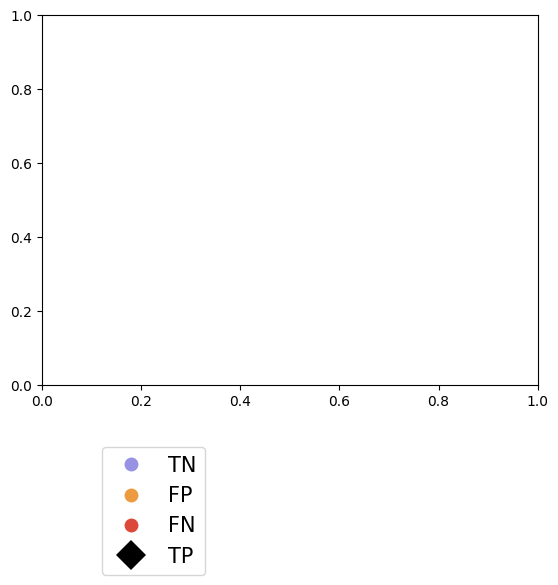

In [36]:
from matplotlib.lines import Line2D    
fig, ax=plt.subplots()

pred_markers = {'TP': 'D','TN': 'o', 'FP': 'o', 'FN': 'o'}
pred_sizes = {'TP': 150, 'TN': 95, 'FP': 97, 'FN': 97}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}

truepos = Line2D([0],[0], marker='D', linestyle='None',markersize=15, markerfacecolor='black', markeredgewidth=0, label='TP')
falsepos = Line2D([0],[0], marker='o', linestyle='None',markersize=10, markerfacecolor='#ED9B40', markeredgewidth=0, label='FP')
trueneg= Line2D([0], [0], marker='o', linestyle='None', markersize=10, markerfacecolor='#9792E3', markeredgewidth=0, label='TN')
falseneg = Line2D([0], [0],  marker='o', linestyle='None', markersize=10, markerfacecolor='#DC493A', markeredgewidth=0, label='FN')

ax.legend(handles=[trueneg, falsepos, falseneg, truepos], ncols=1, bbox_to_anchor=(.35, -.14),fontsize=15)


In [ ]:
sampling_combos

In [92]:
samp_palette={'no_samp': 'tab:blue','UNDER': 'tab:orange','SMOTE': 'hotpink','ADASYN': 'tab:red',
 'no_sampling_RF': 'cornflowerblue','no_sampling_RF_BCW': 'lavender','UNDER_RF': 'orange','no_sampling_BRFC': 'blue',
 'SMOTE_RF': 'hotpink','ADASYN_RF': 'red','no_samp_BRFC_BCW': 'black',
 'no_sampling_BRFC_BCW': 'black','no_sampling_GP_RBF': 'cornflowerblue',
 'UNDER_GP_RBF': 'orange','SMOTE_GP_RBF': 'hotpink','ADASYN_GP_RBF': 'red','no_sampling_GP_matern': 'cornflowerblue',
 'UNDER_GP_matern': 'orange','SMOTE_GP_matern': 'hotpink','ADASYN_GP_matern': 'red',
 'no_samp_Bstrp Under':'blue', 'no_samp_RF':'cornflowerblue', 
    'no_samp_Bstrp Under BalWeight':'black', 'no_samp_RF_BalWeight':'lavender'}

In [93]:
def plot_std_dist_moemfp_reg_legend(dfs,true_labels):
    moe_dfs=[] 
    mfp_dfs = []
    for df in dfs:
        print(df['feat_type'].iloc[0])
        std1 = df['std1'] 
        std0 =df['std0'] 
        ad_dist = df['ADdist'] 
        predictions=df['prediction']
        true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
        true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
        false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
        false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 
        tp_std1 = std1[true_pos]
        tn_std0 = std0[true_neg]
        fp_std1 = std1[false_pos]
        fn_std1 = std1[false_neg]
        tp_ad = ad_dist[true_pos]
        tn_ad = ad_dist[true_neg]
        fp_ad = ad_dist[false_pos]
        fn_ad = ad_dist[false_neg] 
        df['std of probabilities']= np.concatenate([tp_std1,tn_std0,fp_std1, fn_std1])
#         if df['feat_type'].iloc[0] == 'MOE': 
#             this_df = df[df['feat_type'] == 'MOE']
#             moe_dfs.append(this_df)
    
#         elif df['feat_type'].iloc[0] == 'MFP': 
#             this_df = df[df['feat_type'] == 'MFP']
#             mfp_dfs.append(this_df)
        
#     full_moe_df = pd.concat(moe_dfs)
#     full_mfp_df = pd.concat(mfp_dfs)

#     fig, axs = plt.subplots(1,2, figsize=(14,6), sharey=False)
#     sns.kdeplot(data=full_moe_df, x='std of probabilities', hue='strategy',
#                 palette=samp_palette, ax=axs[0])
#     axs[0].set_title('MOE', fontsize=16)
#     sns.kdeplot(data=full_mfp_df, x='std of probabilities', hue='strategy',
#                 palette=samp_palette, ax=axs[1])
#     axs[1].set_title('MFP', fontsize=16)
#     for i, val in enumerate(axs): 
#         axs[i].set_xlabel('Std of Probability', fontsize=16)
#         axs[i].set_ylabel('Density', fontsize=16)
#         axs[i].get_legend().remove()
#         axs[i].set(xlim=(-0.2, .75))
#         axs[i].set(ylim=(0, 6))

#     labels = []
#     handles = []
#     for samp in rf_final['strategy'].unique():
#         if samp in spec_map:
#             label = f'{samp}: {spec_map[samp]}, {recall_map[samp]}'
#             color = special_palette5[samp]
#             labels.append(label)
#             handles.append(Line2D([0],[0], color=color, lw=2))
#     # plt.legend(handles, labels, title=f'{moemfp}\nDataset: specificity, sensitivity', loc='upper left', bbox_to_anchor=(1.05, .7))
#     ax.legend(handles, labels, title=f'{moemfp}\nDataset: specificity, sensitivity', loc='upper left')
#     plt.show();

In [106]:
def plot_std_dist_moemfp_reg_legend(dfs, moemfp, ax,title=None):
    all_dfs = []
    
    for df in dfs:
        std1 = df['std1'] 
        std0 =df['std0'] 
        ad_dist = df['ADdist'] 
        predictions=df['prediction']
        true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
        true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
        false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
        false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 
        tp_std1 = std1[true_pos]
        tn_std0 = std0[true_neg]
        fp_std1 = std1[false_pos]
        fn_std1 = std1[false_neg]
        tp_ad = ad_dist[true_pos]
        tn_ad = ad_dist[true_neg]
        fp_ad = ad_dist[false_pos]
        fn_ad = ad_dist[false_neg] 
        df['std of probabilities']= np.concatenate([tp_std1,tn_std0,fp_std1, fn_std1])
        all_dfs.append(df)


    strategy_cm_map = {}
    recall_map = {}
    spec_map = {}
    full_df = pd.concat(all_dfs)
    for samp in full_df['strategy'].unique(): 
        samp_df= full_df[full_df['strategy'] == samp]
        strategy = samp_df['strategy'].iloc[0]
        recall_map[strategy] = f"{samp_df['sensitivity'].iloc[0]:.2f}"
        spec = samp_df['1-specificity'].iloc[0] 
        spec_map[strategy] = f"{samp_df['1-specificity'].iloc[0]:.2f}"
    
    sns.kdeplot(data=full_df, x='std of probabilities', hue='strategy',palette=samp_palette,ax=ax)
    ax.set_title(moemfp, fontsize=18)
    ax.set_xlabel('Std of Probability', fontsize=16)
    ax.set_ylabel('Density', fontsize=15)
    ax.set(xlim=(-0.2, 0.6))
    ax.set(ylim=(0,6))

    labels = []
    handles = []
    for samp in full_df['strategy'].unique():
        if samp in spec_map:
            label = f'{samp}: {spec_map[samp]}, {recall_map[samp]}'
            color = samp_palette[samp]
            labels.append(label)
            handles.append(Line2D([0],[0], color=color, lw=2))
    # plt.legend(handles, labels, title=f'{moemfp}\nDataset: specificity, sensitivity', loc='upper left', bbox_to_anchor=(1.05, .7))
    ax.legend(handles, labels, title=f'{moemfp}\nDataset: 1-specificity, sensitivity', loc='upper left')

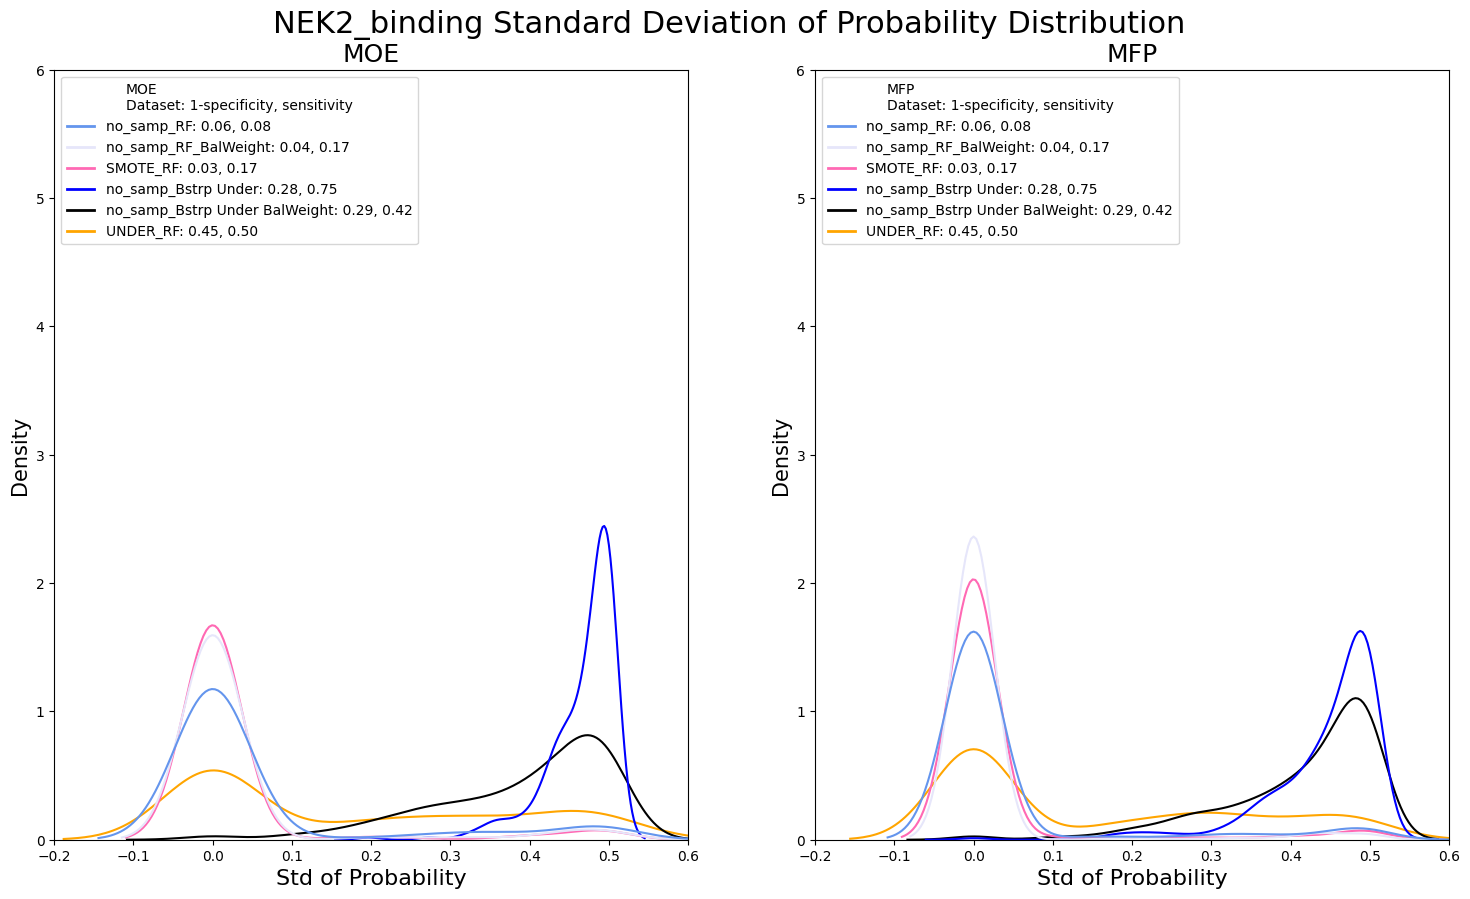

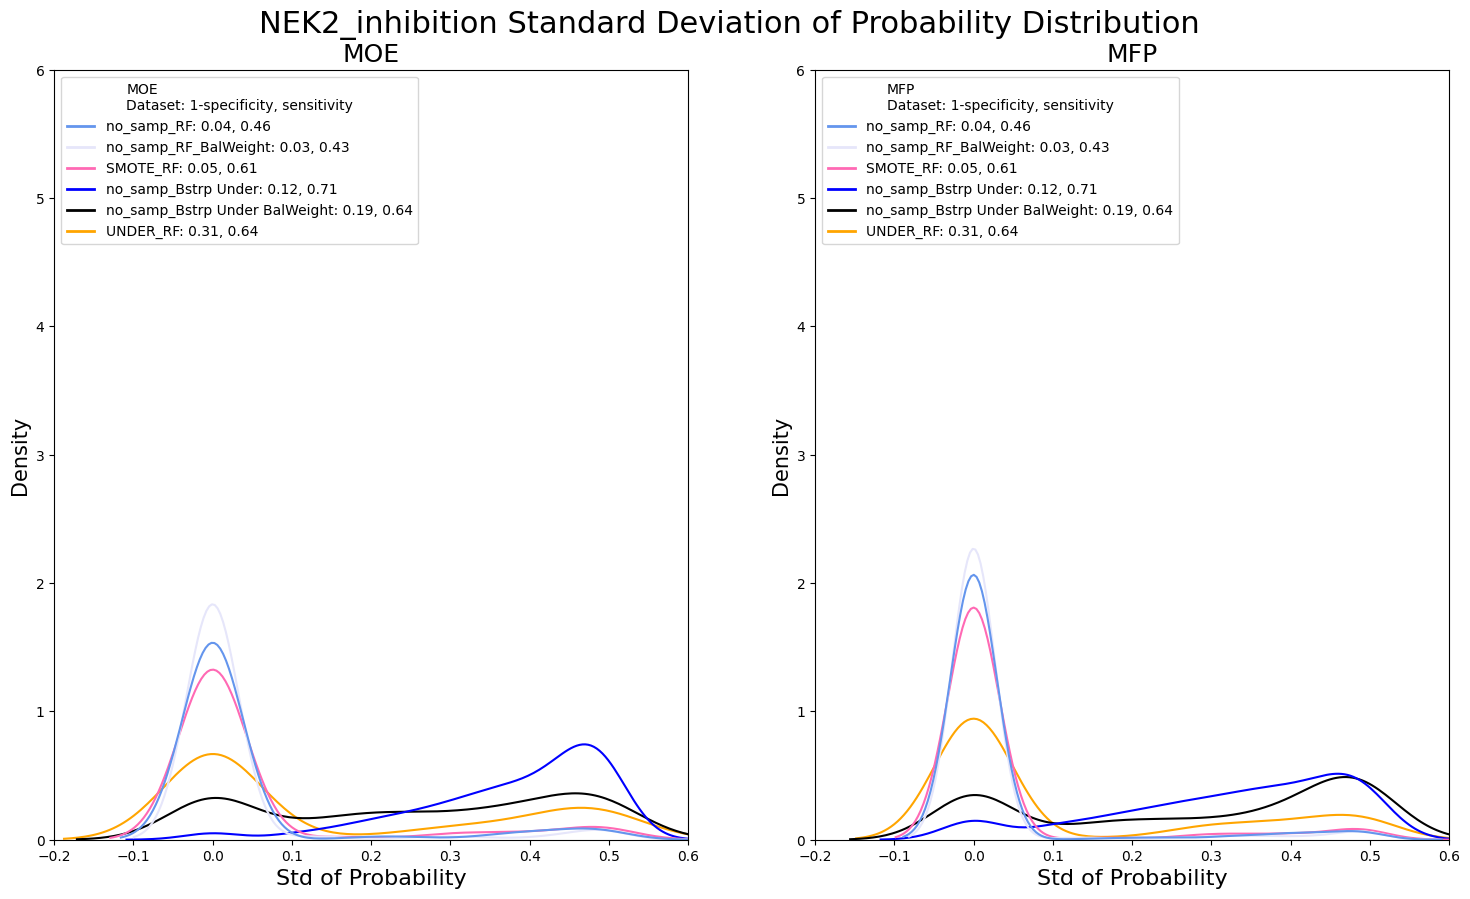

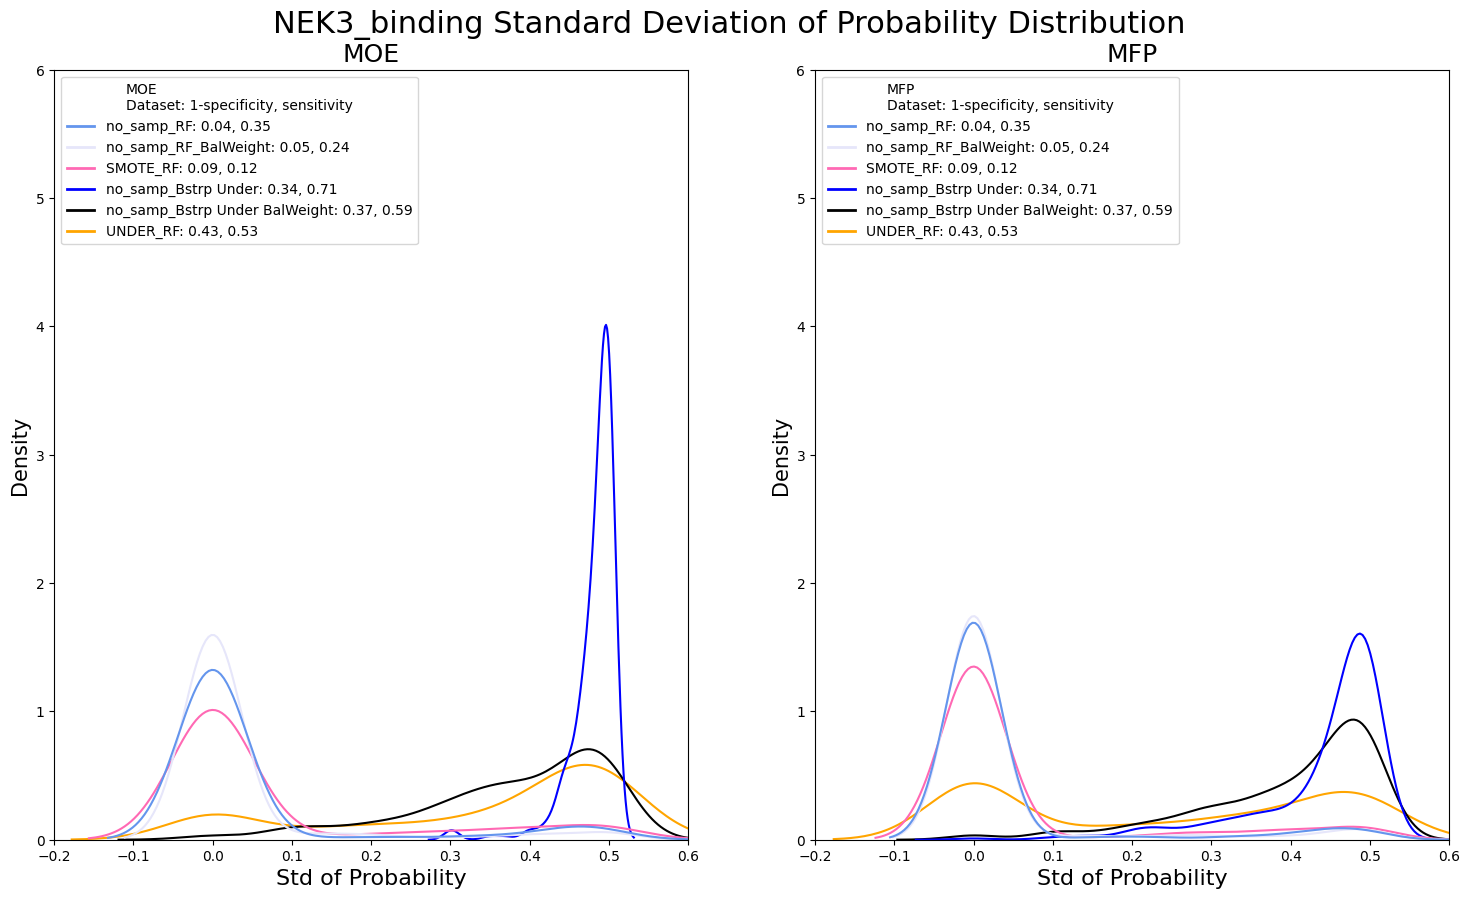

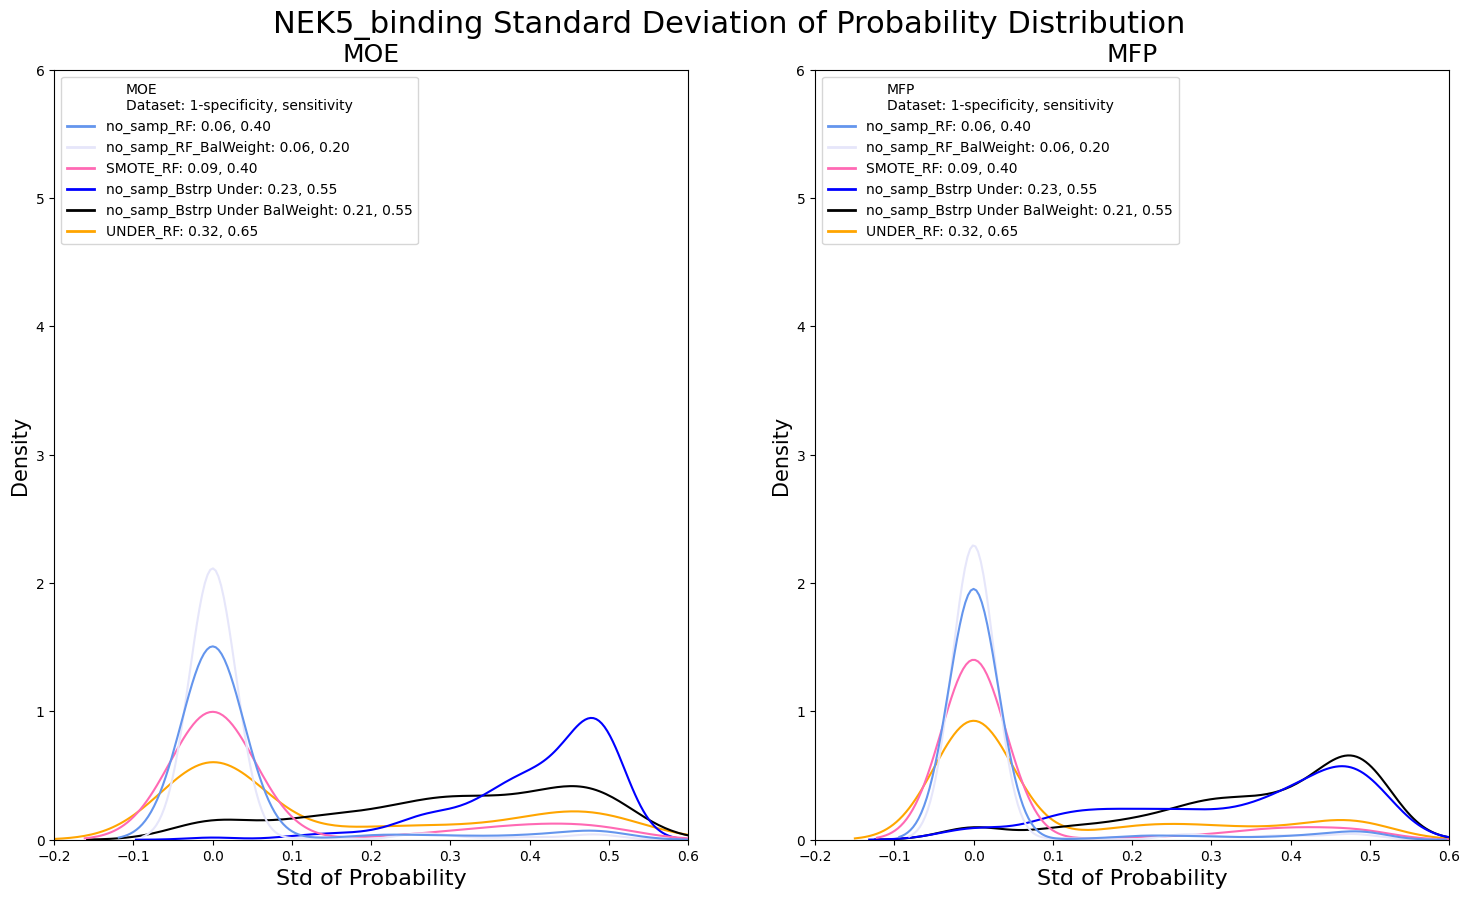

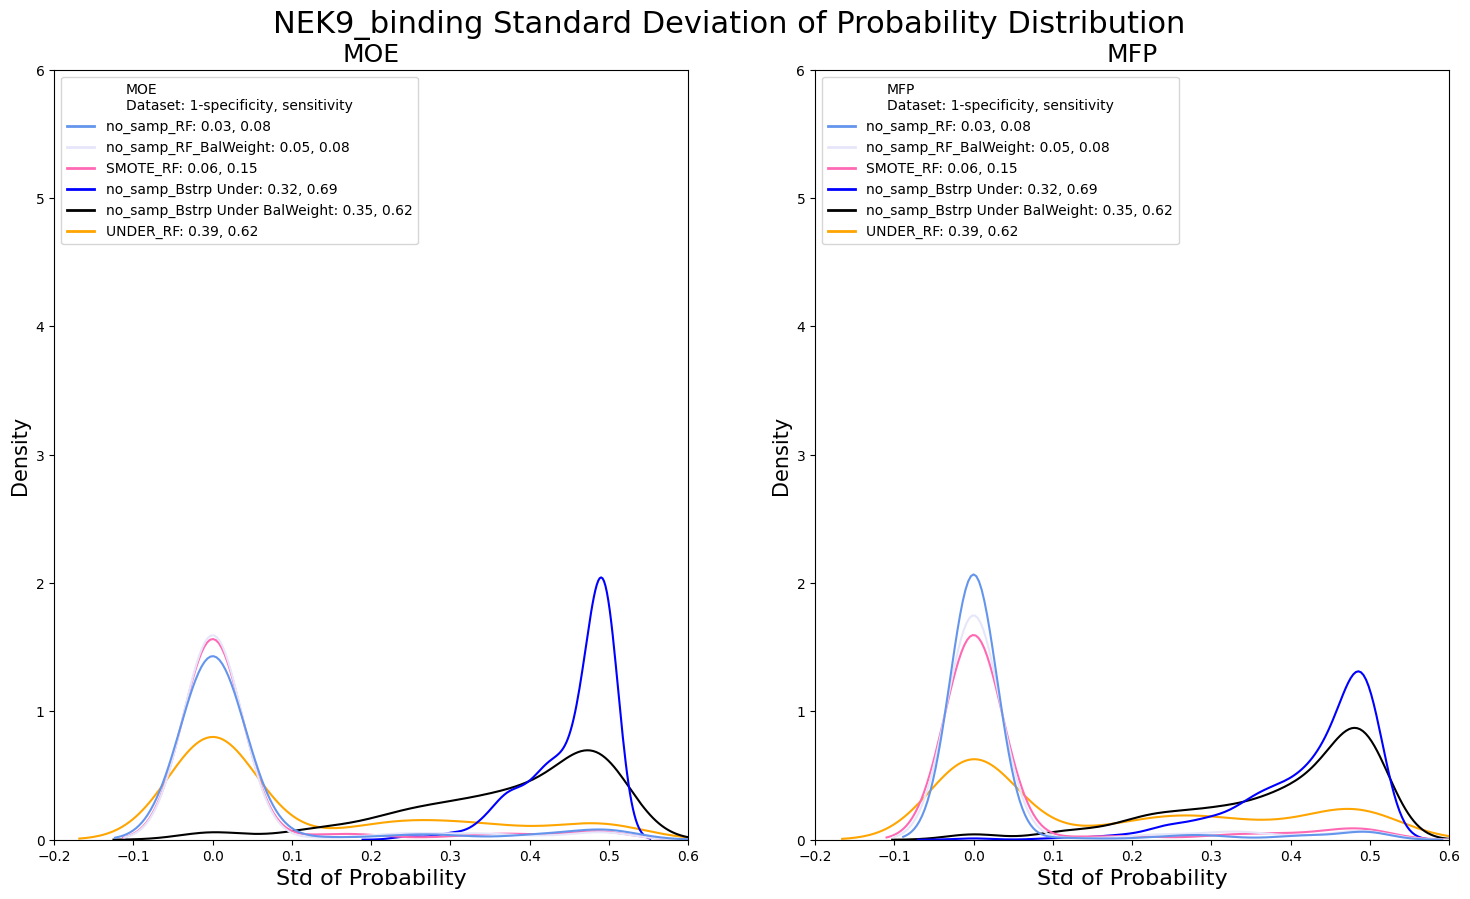

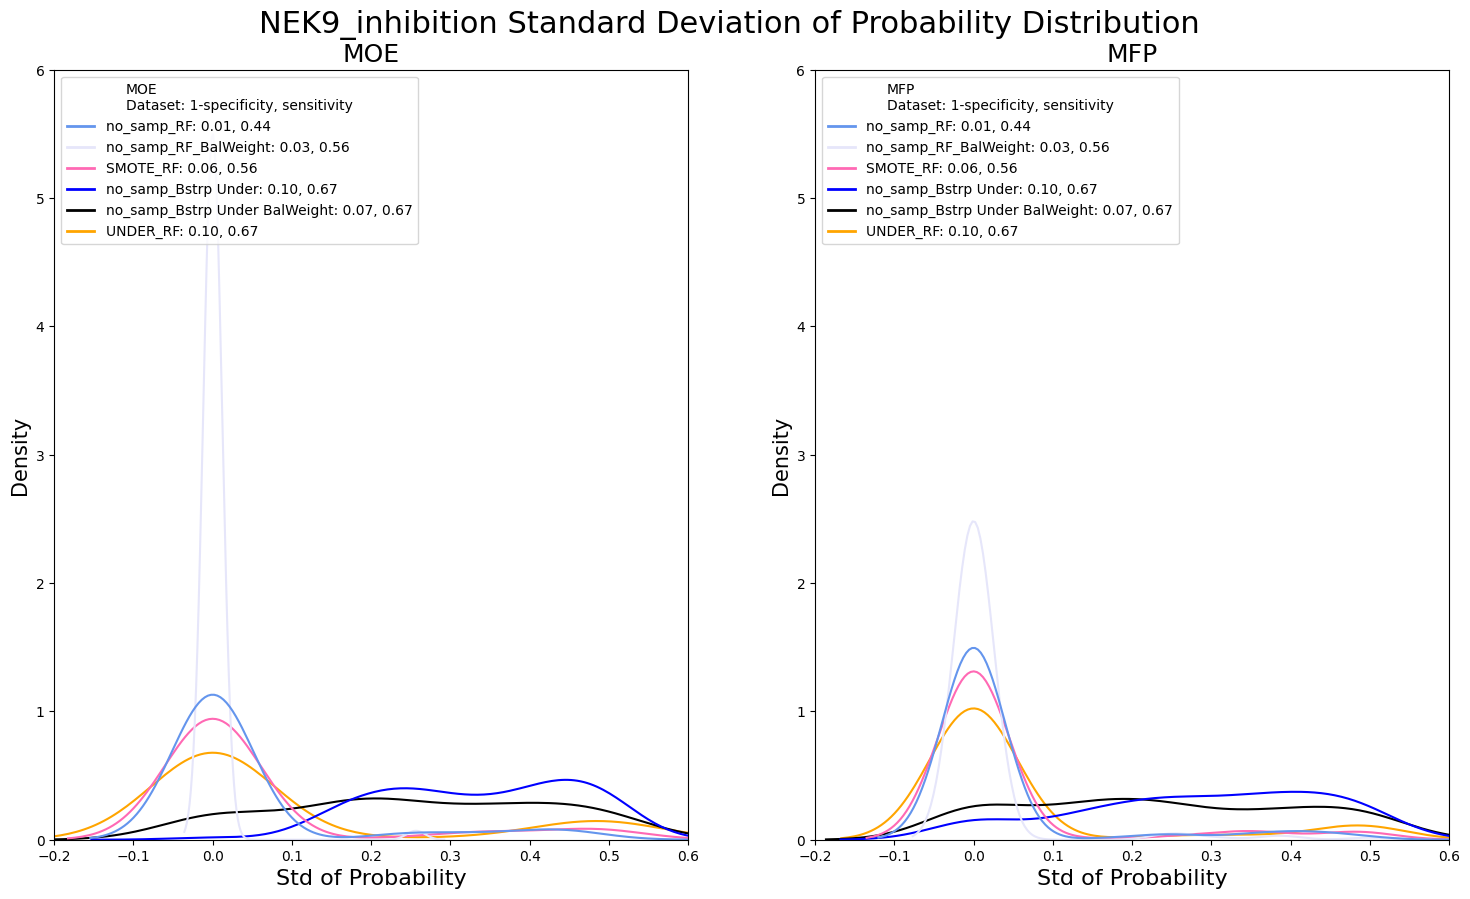

In [109]:
figpath=f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/RF/stdprob_dist/'
for nek in neks:
    dfs = [] 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,10))
    for j,feat in enumerate(feats): 
        for count, (samp,rf) in enumerate(sampling_combos):
            root_name = f'{nek}_{feat}_{samp}'
            results_df = pd.read_csv(f'{results_path}{nek}_{feat}_{samp}_{rf}_prod_test.csv')
            data_df = pd.read_csv(f'{datapath}{root_name}.csv')
            with open(f'{results_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
                model = pickle.load(f) 
            train_dist, test_dist, std0, std1=get_plotting_data_RF_UQ(results_df,data_df,model)
            results_df['1-specificity'] = 1-results_df['specificity'] 
            true_labels =results_df['y'].to_numpy()
            results_df=change_names(results_df)
            results_df['strategy']=results_df['strategy'].astype(str)+'_'+results_df['RF_type']
            cm =results_df['cm'][0]
            df = pd.DataFrame({'prediction': results_df['prediction'],'std0': std0,'std1': std1,'ADdist': test_dist,
                'strategy':results_df['strategy'],'feat_type': results_df['feat_type'], 'RF_type': results_df['RF_type'],
                'sensitivity':results_df['recall'], '1-specificity': results_df['1-specificity'],'cm': cm})
            dfs.append(df)
       
        plot_std_dist_moemfp_reg_legend(dfs, feat,axes[j])
    
    fig.suptitle(f'{nek} Standard Deviation of Probability Distribution', fontsize=22,y=0.94)
    filename = f'{nek}_{feat}_RF_prob_std_dist'
    plt.savefig(f'{figpath}{filename}.png',bbox_inches='tight')
    plt.show();
      